In [1]:
%load_ext autoreload
%autoreload 2
from itertools import product
import warnings; warnings.simplefilter('ignore')

#from datasets import get_dataset
#from train_eval import cross_validation_with_val_set

#from gcn import GCN, GCNWithJK
#from graph_sage import GraphSAGE, GraphSAGEWithJK
#from gin import GIN0, GIN0WithJK, GIN, GINWithJK
#from graclus import Graclus
#from top_k import TopK
#from diff_pool import DiffPool
#from sag_pool import SAGPool
#from global_attention import GlobalAttentionNet
#from set2set import Set2SetNet
#from sort_pool import SortPool

import time, os
import argparse
import yaml
from pprint import pprint
import logging
import os

from pathlib import Path
import sys
import inspect
import pkgutil
from importlib import import_module

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool, JumpingKnowledge
from torch import tensor
from torch.optim import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from torch_geometric.data import DataLoader, DenseDataLoader as DenseLoader

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir+'/graph_classification') 

from TFM_graph_classification import *
from TFM_graph_classification_models import *
from TFM_function_renaming_dataset_creation import *

from TFM_function_renaming_dataset_creation import *
from TFM_function_renaming_dataset_creation import FunctionsDataset
from TFM_function_renaming_baseline_models import *
from TFM_function_renaming_preprocess_dataset_splits import *


import logging

logger = logging.getLogger('exp2')
#logger.basicConfig(filename='exp2-gnn.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s')
f_handler = logging.FileHandler('exp2-gnn.log')
f_handler.setLevel(logging.DEBUG)
logger.addHandler(f_handler)

## Distribution analysis

First get the exact class imbalance and the proportion of majority class, see if it's the same as the accuracy obtained.

Then show the distribution of each topologic and code feature, segmented by class and with all the population, to see if the classes are similar or there is some discriminative power within the graphs.



In [85]:
def histogram_of_a_features(colnum, X_train, y_train, feature_names, prefix):
    # now histogram of one column segmented by y_train
    feature = X_train[:,colnum]
    classes = y_train

    feature_dict = {}
    for j in range(len(feature)):
        if classes[j] not in feature_dict.keys():
            feature_dict[classes[j]]=[]
        feature_dict[classes[j]].append(feature[j])

    rows=20
    cols=2
    gs = gridspec.GridSpec(rows, cols)
    fig=plt.figure(figsize=(14, 100), dpi= 60, facecolor='w', edgecolor='k')
    n=0
    for class_ in feature_dict.keys():
        ax =fig.add_subplot(gs[n])
        n+=1


        ax.hist(feature_dict[class_],alpha=0.5, density=True, label=str(class_))
        ax.hist(feature.tolist(), alpha=0.5, density=True, label="total population")

        ax.set_title(feature_names[colnum]+": class "+str(class_)+" vs total population")
        ax.legend()
        plt.savefig(feature_names[colnum]+"_C"+str(class_))
        plt.plot()

        
def histograms_of_all_features(X_train, y_train, feature_names, prefix=''):
    feats = X_train.shape[1]
    
    for j in range(feats):
        if j==0 or j==1:
            continue
        histogram_of_a_features(j,X_train, y_train, feature_names, prefix)

features_names={
    0: 'document',
    1: 'document_simplified',
    2: 'list_funcs',
    3: 'nregs',
    4: 'number of distinct registers',
    5: 'number of instructions',
    6: 'number of displacements',
    7: 'number of immediates',
    8: 'number of addresses',
    9: 'number of functions',
    10: 'size',
    11: 'diameter',
    12: 'radius',
    13: 'average degree',
    14: 'density',
    15: 'connectivity',
    16: 'average clustering',
    17: 'average shortests path length',
    18: 'degree assortativity',
    19: 'degree pearson correlation coefficient',
}


In [166]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec


labels_v1 = {
    "network": 0, 
    "unk": 1,
    "disk": 2,
    "memory": 3,
    "gui": 4,
    "process": 5,
    "computation": 6,
    "datastruct": 7,
    "cryptography": 8,
    "users": 9,
    "All": "All"
}

labels_v3 = {
    "unk": 0, 
    "cryptography_encrypt": 1, 
    "computation": 2, "gui_config": 3,
    "process_sync": 4, "process_config": 5,
    "datastruct": 6, "gui": 7, "memory": 8,
    "memory_config": 9, "process": 10,
    "disk_read": 11, "network_send": 12,
    "memory_write": 13, "cryptography": 14,
    "network_config": 15, "network_parse": 16,
    "network": 17, "users": 18, "disk_file": 19,
    "disk": 20, "memory_read": 21, "cryptography_config": 22,
    "disk_write": 23,
    "All": "All"
}


def boxplot_of_a_features(colnum, X_train, y_train, feature_names, prefix, labels=labels_v1):
    # now histogram of one column segmented by y_train
    feature = X_train[:,colnum]
    classes = y_train

    feature_dict = {}
    for j in range(len(feature)):
        if classes[j] not in feature_dict.keys():
            feature_dict[classes[j]]=[]
        feature_dict[classes[j]].append(feature[j])

    rows=20
    cols=2
    gs = gridspec.GridSpec(rows, cols)
    fig=plt.figure(figsize=(8, 5), dpi= 60, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots()
    n=0
    #for class_ in feature_dict.keys():
    #    ax =fig.add_subplot(gs[n])
    #    n+=1
    #    ax.boxplot(feature_dict[class_])
    #    ax.set_xticklabels(label=str(class_))
    #pprint(feature_dict)
    
    classes_names = list(feature_dict.keys())
    #print(classes_names)
    classes_names.sort(key=lambda x: x)
    
    new_labels = {}
    for k,v in labels.items():
        new_labels[v]=k
    #print(new_labels)
        
    classes_str_names = list(classes_names)
    for jj in range(len(classes_names)):
        classes_str_names[jj]=new_labels[classes_names[jj]]
    
    
    values = []
    for c in classes_names:
        values.append(feature_dict[c])
        
    classes_names.append('All')
    classes_str_names.append('All')
    values.append(feature.tolist())
    #print(classes_names)
    
    max_val = 0
    min_val = 10
    for vlist in values:
        for v in vlist:
            if v> max_val:
                max_val= v
            if v < min_val:
                min_val = v
    
    
    #ax.boxplot(np.log10(values))
    ax.boxplot(values)
    ax.set_xticklabels(classes_str_names)
    plt.xticks(rotation=45)
    ax.set_yscale('log')
    ax.set_ylim(min(-100,min_val-1),max_val)

    ax.set_title(feature_names[colnum])
    plt.tight_layout()
    filename='../../doc/img/boxplots/'+prefix+feature_names[colnum].replace(' ','_')
    plt.savefig(filename)
    s = "\\minipage{{0.5\\textwidth}}%\n\\centering\n\\includegraphics[width=0.9\\linewidth]{{img/boxplots/{}.png}}\n\\endminipage".format(filename)
    print(s)
    print()
    plt.plot()

        
def boxplots_of_all_features(X_train, y_train, feature_names, prefix, labels=labels_v1):
    feats = X_train.shape[1]
    
    for j in range(feats):
        if j<3:
            continue
        boxplot_of_a_features(j,X_train, y_train, feature_names, prefix, labels)

features_names={
    0: 'document',
    1: 'document_simplified',
    2: 'list_funcs',
    3: 'nregs',
    4: 'number of distinct registers',
    5: 'number of instructions',
    6: 'number of displacements',
    7: 'number of immediates',
    8: 'number of addresses',
    9: 'number of functions',
    10: 'size',
    11: 'diameter',
    12: 'radius',
    13: 'average degree',
    14: 'density',
    15: 'connectivity',
    16: 'average clustering',
    17: 'average shortests path length',
    18: 'degree assortativity',
    19: 'degree pearson correlation coefficient',
}


## V1 Dataset

In [156]:
# verify class proportions
dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()
labels = dataset.y.flatten().tolist()
props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)


processed_path tmp/symbols_dataset_1_precomp_split_undersample_max/training_set/processed
{0.0: 3445,
 1.0: 943,
 2.0: 1294,
 3.0: 521,
 4.0: 3400,
 5.0: 1046,
 6.0: 820,
 7.0: 3426,
 8.0: 22,
 9.0: 116}


\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_unbalanced_nregs.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_unbalanced_number_of_distinct_registers.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_unbalanced_number_of_instructions.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_unbalanced_number_of_displacements.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_unbalanced_number_of_immediates.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_unbalanced_number_of_addresses.png}
\endminipage

\minipage{0.5

<Figure size 480x300 with 0 Axes>

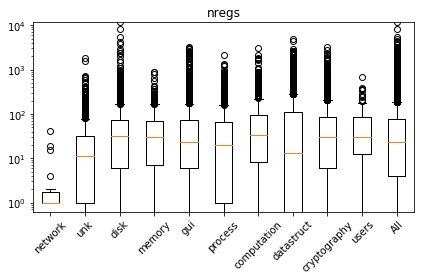

<Figure size 480x300 with 0 Axes>

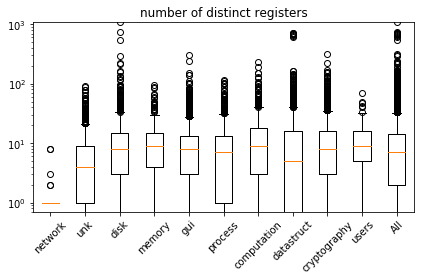

<Figure size 480x300 with 0 Axes>

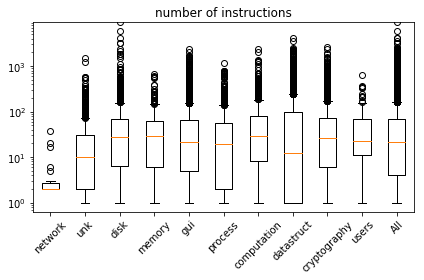

<Figure size 480x300 with 0 Axes>

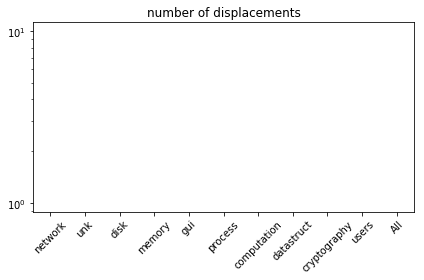

<Figure size 480x300 with 0 Axes>

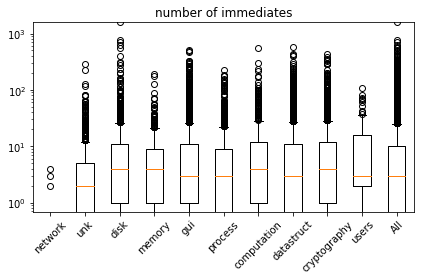

<Figure size 480x300 with 0 Axes>

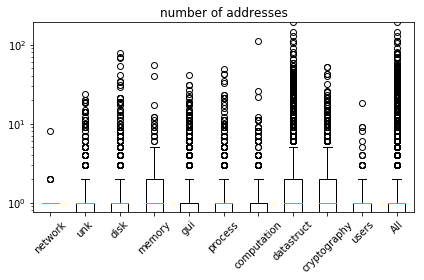

<Figure size 480x300 with 0 Axes>

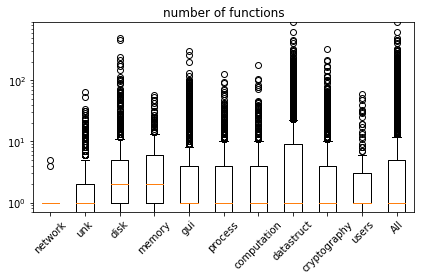

<Figure size 480x300 with 0 Axes>

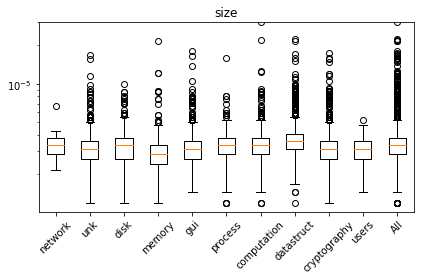

<Figure size 480x300 with 0 Axes>

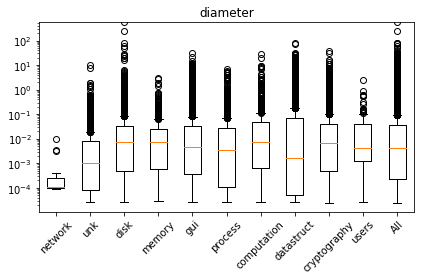

<Figure size 480x300 with 0 Axes>

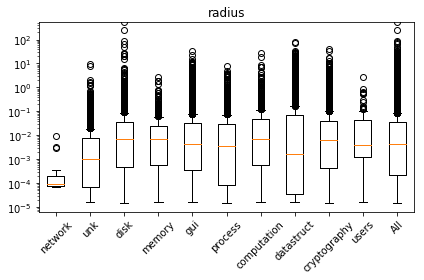

<Figure size 480x300 with 0 Axes>

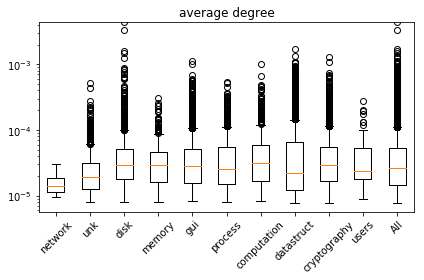

<Figure size 480x300 with 0 Axes>

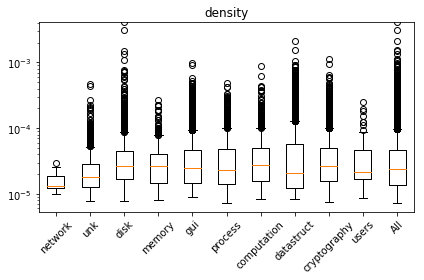

<Figure size 480x300 with 0 Axes>

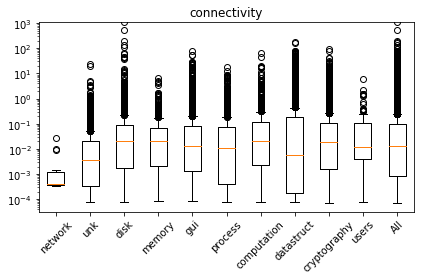

<Figure size 480x300 with 0 Axes>

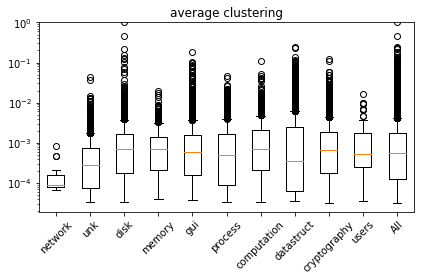

<Figure size 480x300 with 0 Axes>

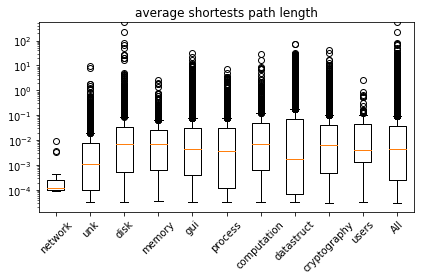

<Figure size 480x300 with 0 Axes>

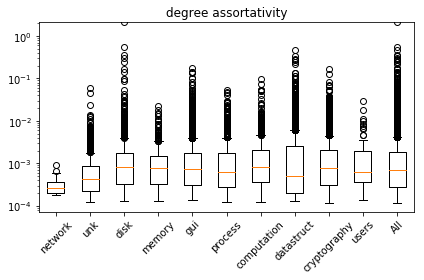

<Figure size 480x300 with 0 Axes>

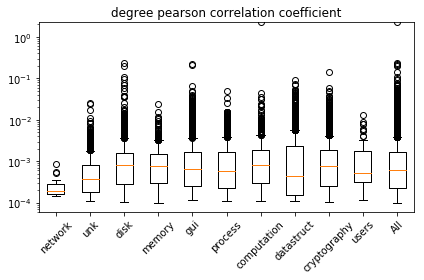

In [167]:
X_train, X_test, y_train, y_test, nclasses = load_dataset_split(
    './tmp/symbols_dataset_1_precomp_split_undersample_max')
boxplots_of_all_features(X_train,y_train,features_names, prefix='v1_unbalanced_')

In [8]:
# verify class proportions
dataset = FunctionsDataset(root='./tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()
labels = dataset.y.flatten().tolist()
props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)


processed_path tmp/symbols_dataset_1_precomp_split_undersample_max3/training_set/processed
{1.0: 593, 2.0: 633, 3.0: 523, 4.0: 612, 5.0: 632, 6.0: 618, 7.0: 620, 8.0: 602}


\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_balanced_nregs.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_balanced_number_of_distinct_registers.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_balanced_number_of_instructions.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_balanced_number_of_displacements.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_balanced_number_of_immediates.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v1_balanced_number_of_addresses.png}
\endminipage

\minipage{0.5\textwidth}%

<Figure size 480x300 with 0 Axes>

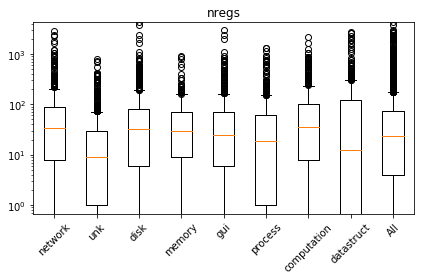

<Figure size 480x300 with 0 Axes>

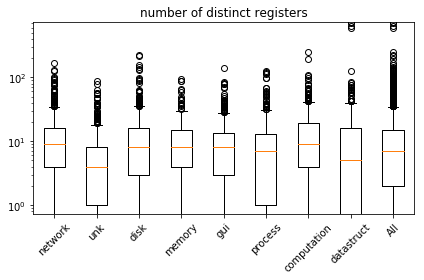

<Figure size 480x300 with 0 Axes>

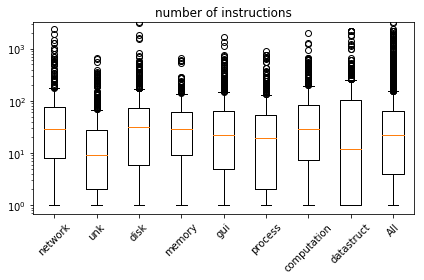

<Figure size 480x300 with 0 Axes>

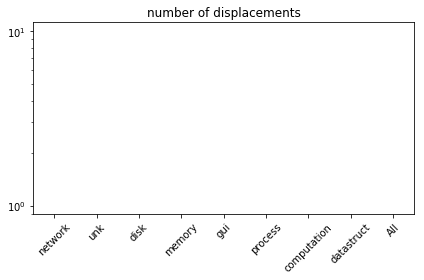

<Figure size 480x300 with 0 Axes>

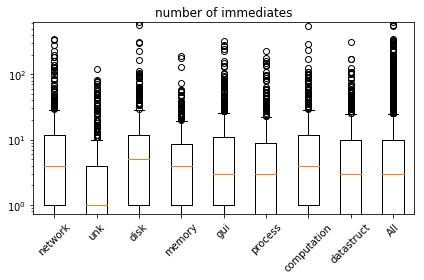

<Figure size 480x300 with 0 Axes>

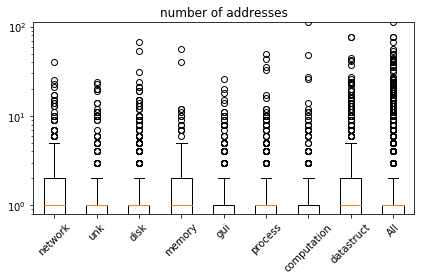

<Figure size 480x300 with 0 Axes>

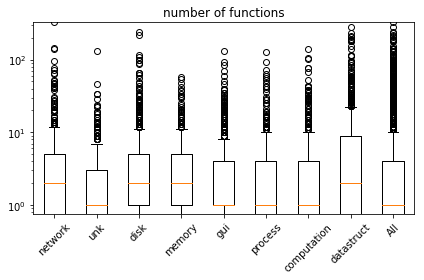

<Figure size 480x300 with 0 Axes>

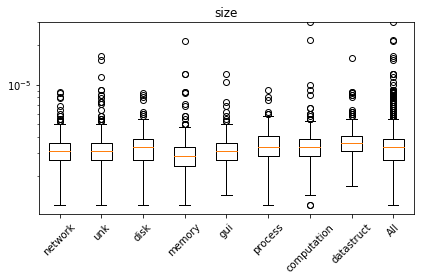

<Figure size 480x300 with 0 Axes>

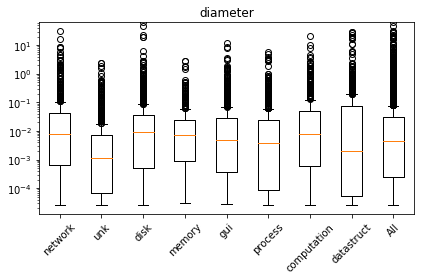

<Figure size 480x300 with 0 Axes>

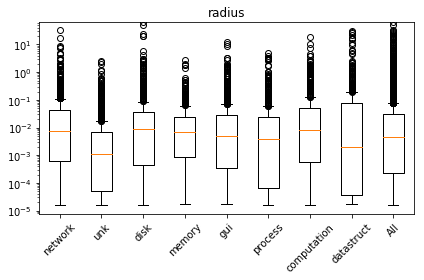

<Figure size 480x300 with 0 Axes>

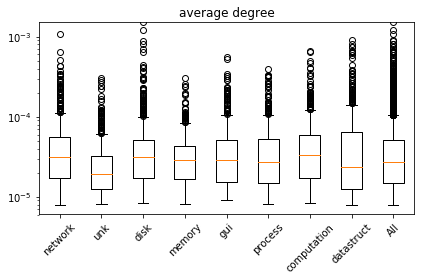

<Figure size 480x300 with 0 Axes>

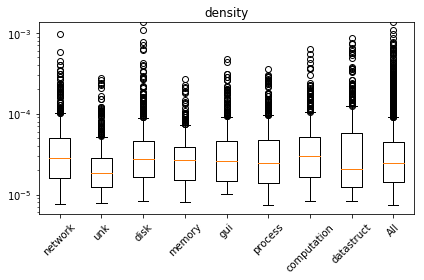

<Figure size 480x300 with 0 Axes>

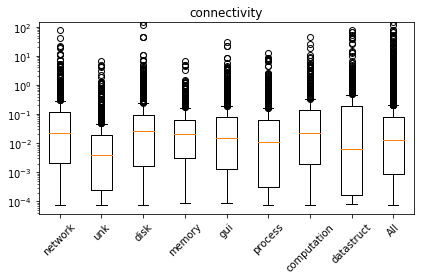

<Figure size 480x300 with 0 Axes>

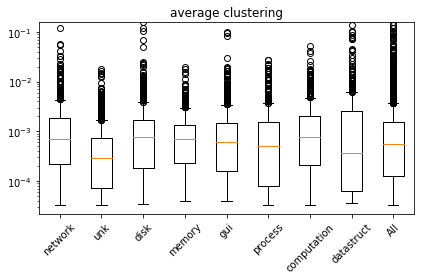

<Figure size 480x300 with 0 Axes>

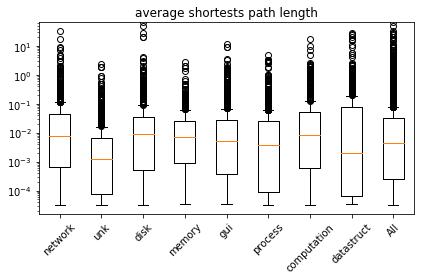

<Figure size 480x300 with 0 Axes>

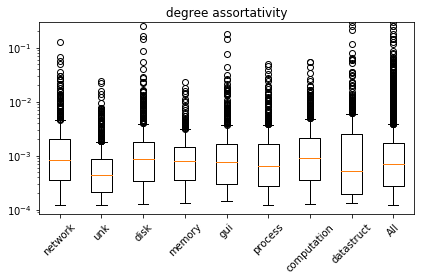

<Figure size 480x300 with 0 Axes>

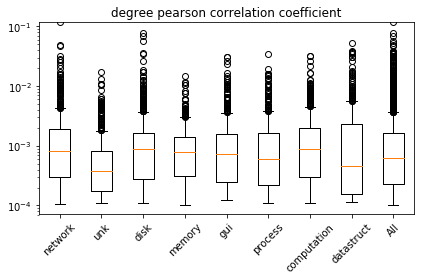

In [169]:
X_train, X_test, y_train, y_test, nclasses = load_dataset_split(
    './tmp/symbols_dataset_1_precomp_split_undersample_max3')
boxplots_of_all_features(X_train,y_train,features_names, prefix='v1_balanced_')

## v3 dataset

In [7]:
# verify class proportions
dataset = FunctionsDataset(root='./tmp/symbols_dataset_3_precomp_split_undersample_max/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()
labels = dataset.y.flatten().tolist()
props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)


processed_path tmp/symbols_dataset_3_precomp_split_undersample_max/training_set/processed
{0.0: 1512,
 1.0: 1510,
 2.0: 1339,
 3.0: 492,
 4.0: 157,
 5.0: 1482,
 6.0: 1458,
 7.0: 1532,
 8.0: 317,
 9.0: 704,
 10.0: 251,
 11.0: 137,
 12.0: 902,
 13.0: 756,
 14.0: 392,
 15.0: 1537,
 16.0: 1084,
 17.0: 37,
 18.0: 76,
 19.0: 527,
 20.0: 9,
 21.0: 206,
 22.0: 1505,
 23.0: 234}


\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_unbalanced_nregs.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_unbalanced_number_of_distinct_registers.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_unbalanced_number_of_instructions.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_unbalanced_number_of_displacements.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_unbalanced_number_of_immediates.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_unbalanced_number_of_addresses.png}
\endminipage

\minipage{0.5

<Figure size 480x300 with 0 Axes>

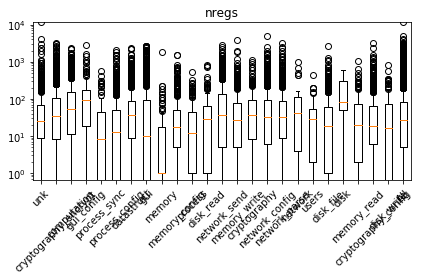

<Figure size 480x300 with 0 Axes>

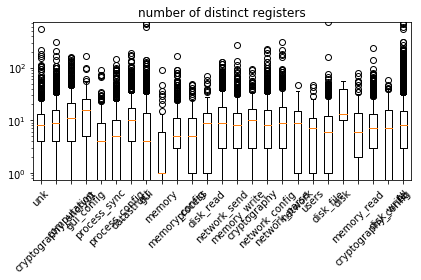

<Figure size 480x300 with 0 Axes>

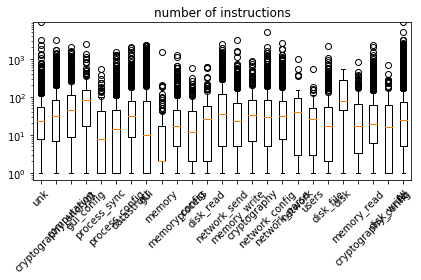

<Figure size 480x300 with 0 Axes>

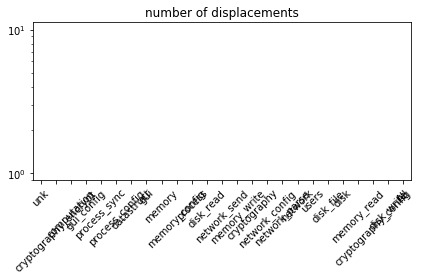

<Figure size 480x300 with 0 Axes>

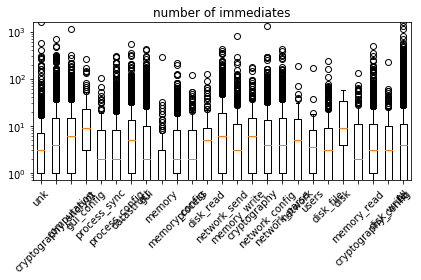

<Figure size 480x300 with 0 Axes>

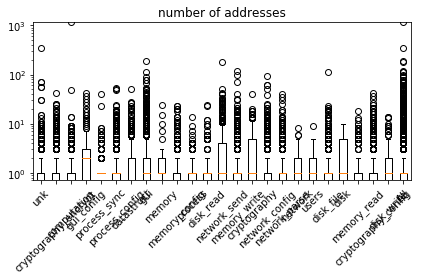

<Figure size 480x300 with 0 Axes>

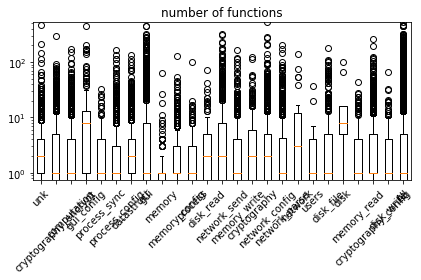

<Figure size 480x300 with 0 Axes>

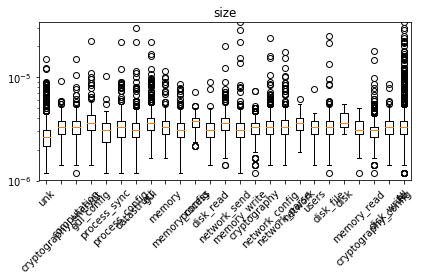

<Figure size 480x300 with 0 Axes>

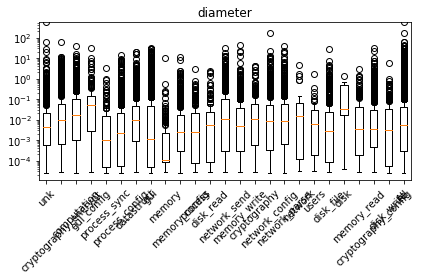

<Figure size 480x300 with 0 Axes>

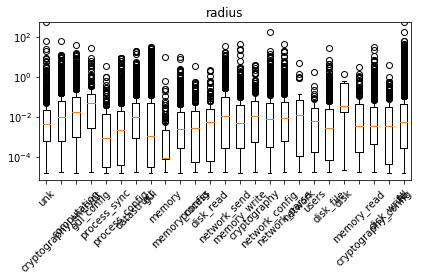

<Figure size 480x300 with 0 Axes>

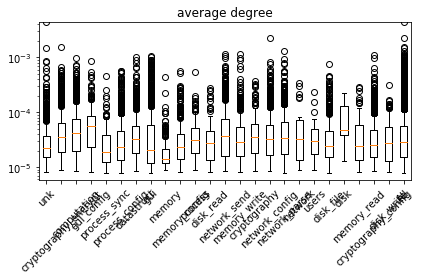

<Figure size 480x300 with 0 Axes>

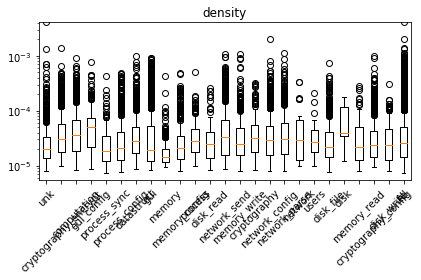

<Figure size 480x300 with 0 Axes>

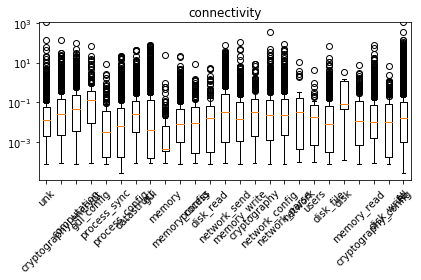

<Figure size 480x300 with 0 Axes>

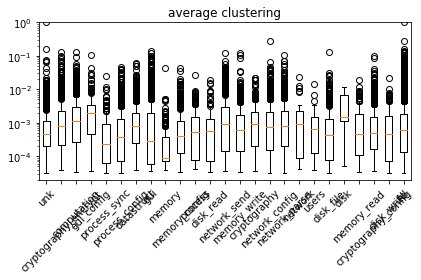

<Figure size 480x300 with 0 Axes>

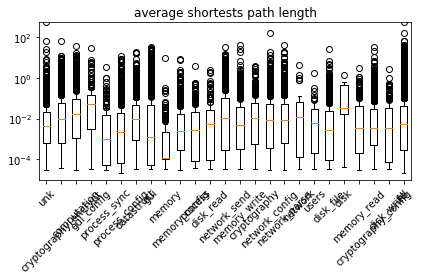

<Figure size 480x300 with 0 Axes>

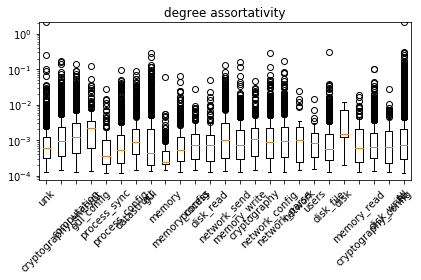

<Figure size 480x300 with 0 Axes>

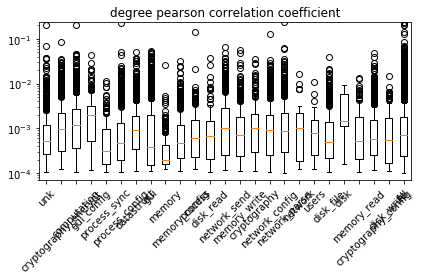

In [168]:
X_train, X_test, y_train, y_test, nclasses = load_dataset_split(
    './tmp/symbols_dataset_3_precomp_split_undersample_max')
boxplots_of_all_features(X_train,y_train,features_names, prefix='v3_unbalanced_', labels=labels_v3)

In [24]:
# verify class proportions
dataset = FunctionsDataset(root='./tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set')
dataset_name='assemblerv3'
dataset.gnn_mode_on()
labels = dataset.y.flatten().tolist()
props ={}
for lab in labels:
    if lab not in props.keys():
        props[lab]=0
    props[lab]+=1
pprint(props)


processed_path tmp/symbols_dataset_3_precomp_split_undersample_max2/training_set/processed
{0.0: 600,
 1.0: 632,
 2.0: 621,
 3.0: 494,
 4.0: 225,
 5.0: 615,
 6.0: 637,
 7.0: 619,
 8.0: 310,
 9.0: 623,
 10.0: 256,
 11.0: 616,
 12.0: 620,
 13.0: 591,
 14.0: 386,
 15.0: 623,
 16.0: 630,
 17.0: 194,
 18.0: 491}


\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_balanced_nregs.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_balanced_number_of_distinct_registers.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_balanced_number_of_instructions.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_balanced_number_of_displacements.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_balanced_number_of_immediates.png}
\endminipage

\minipage{0.5\textwidth}%
\centering
\includegraphics[width=0.9\linewidth]{img/boxplots/../../doc/img/boxplots/v3_balanced_number_of_addresses.png}
\endminipage

\minipage{0.5\textwidth}%

<Figure size 480x300 with 0 Axes>

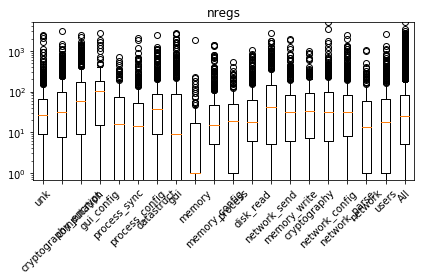

<Figure size 480x300 with 0 Axes>

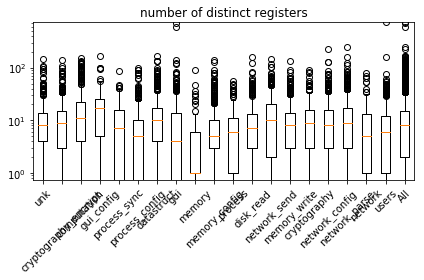

<Figure size 480x300 with 0 Axes>

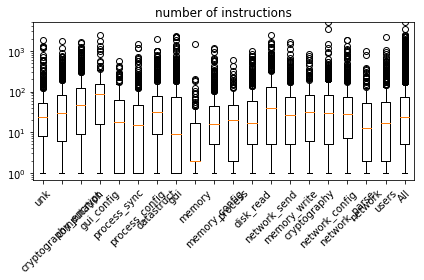

<Figure size 480x300 with 0 Axes>

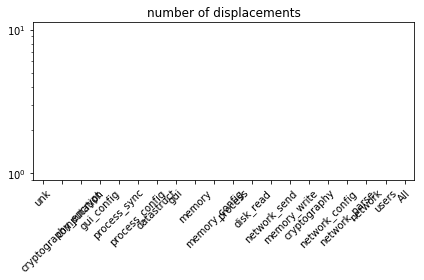

<Figure size 480x300 with 0 Axes>

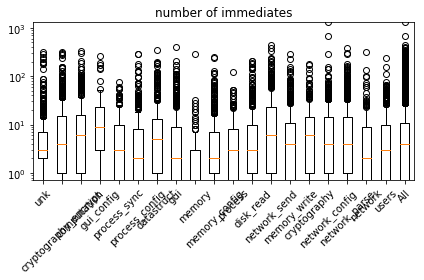

<Figure size 480x300 with 0 Axes>

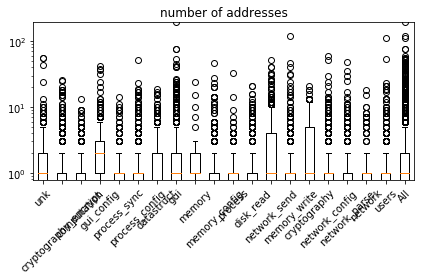

<Figure size 480x300 with 0 Axes>

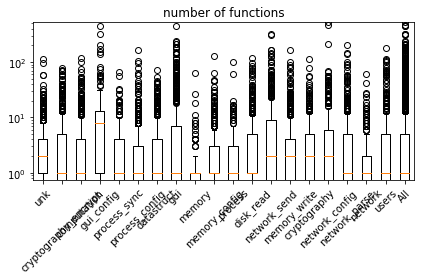

<Figure size 480x300 with 0 Axes>

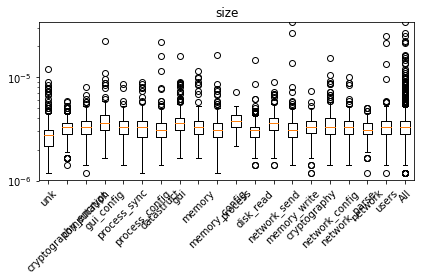

<Figure size 480x300 with 0 Axes>

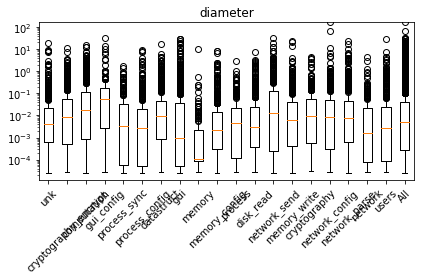

<Figure size 480x300 with 0 Axes>

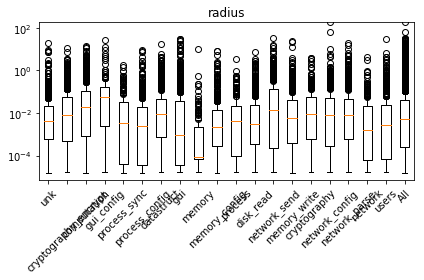

<Figure size 480x300 with 0 Axes>

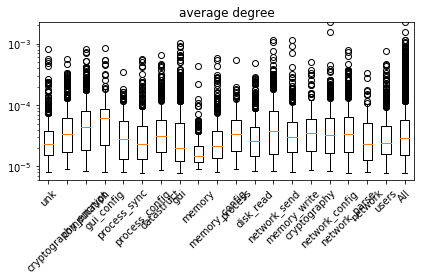

<Figure size 480x300 with 0 Axes>

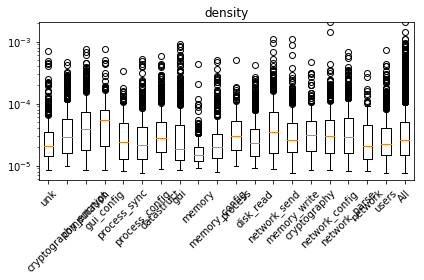

<Figure size 480x300 with 0 Axes>

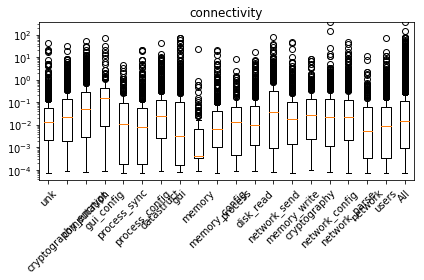

<Figure size 480x300 with 0 Axes>

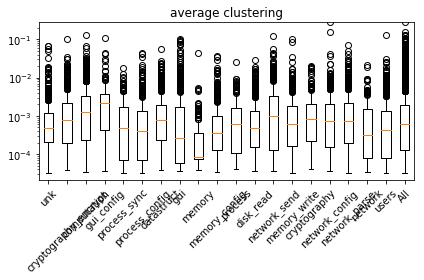

<Figure size 480x300 with 0 Axes>

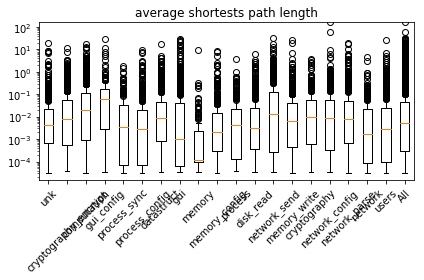

<Figure size 480x300 with 0 Axes>

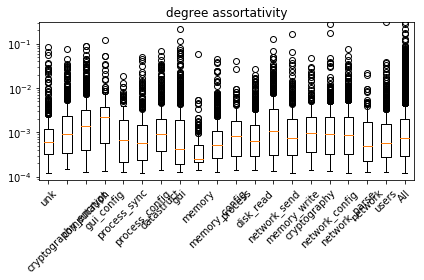

<Figure size 480x300 with 0 Axes>

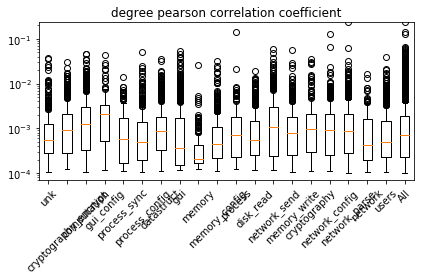

In [170]:
X_train, X_test, y_train, y_test, nclasses = load_dataset_split(
    './tmp/symbols_dataset_3_precomp_split_undersample_max2')
boxplots_of_all_features(X_train,y_train,features_names, prefix='v3_balanced_', labels=labels_v3)

## Histogram Analysis

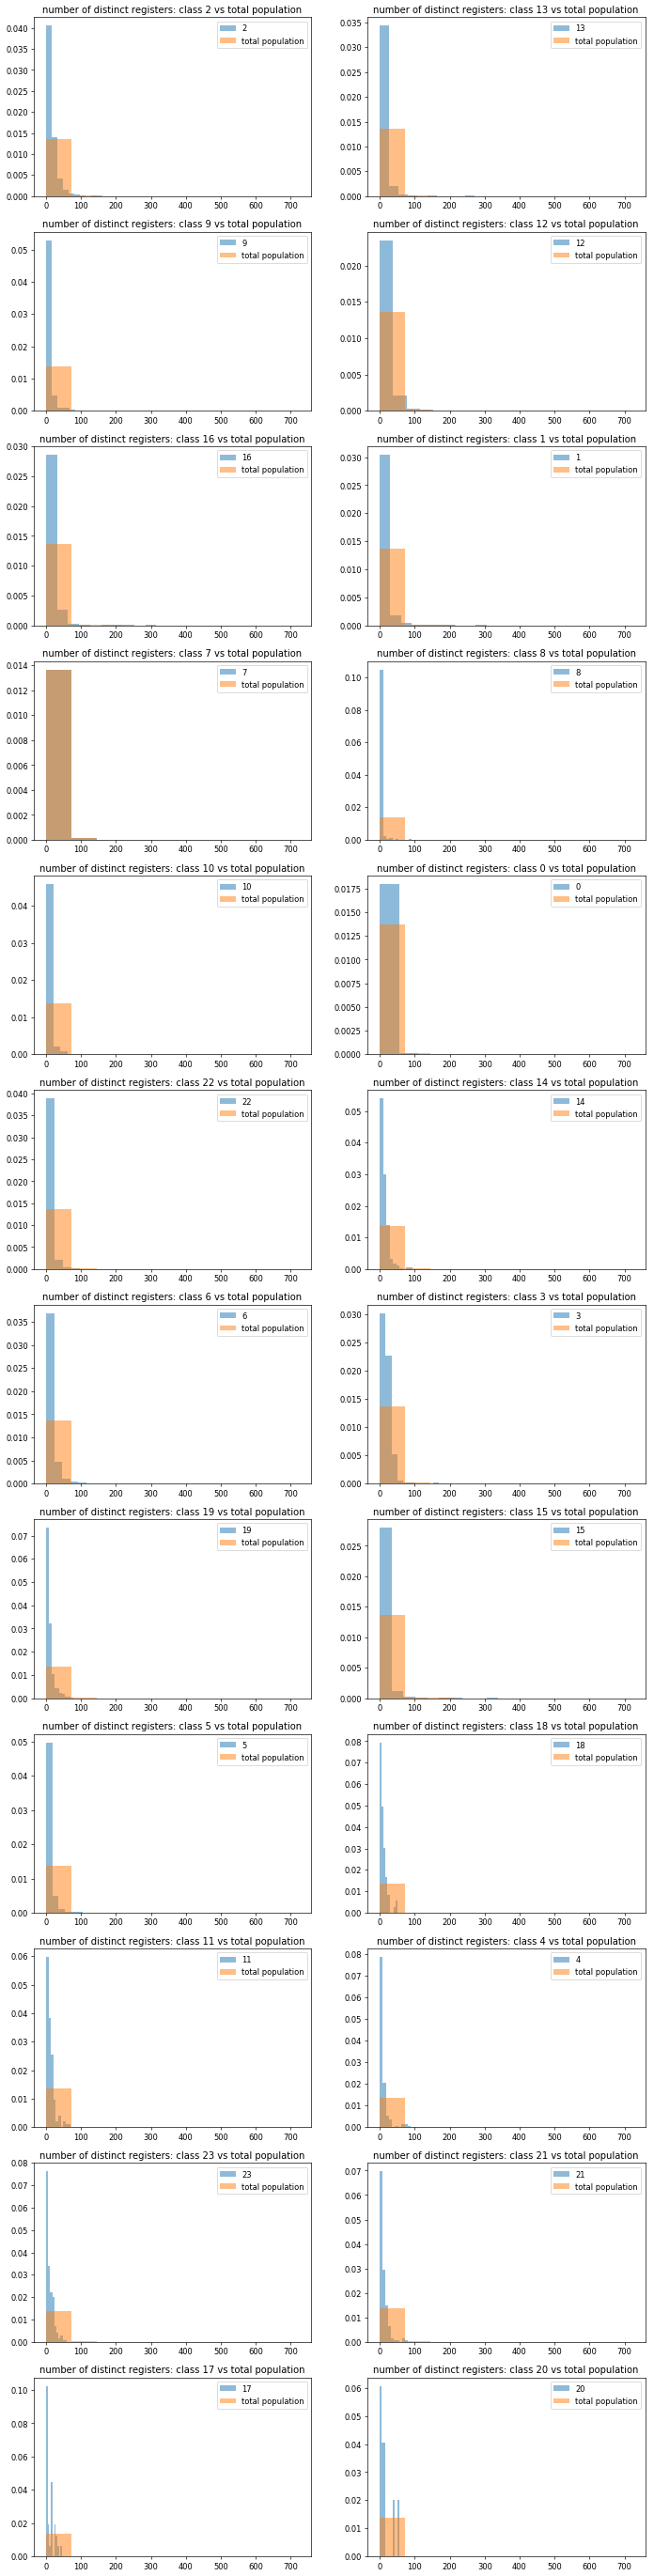

In [43]:
histogram_of_a_features(4,X_train,y_train,features_names)

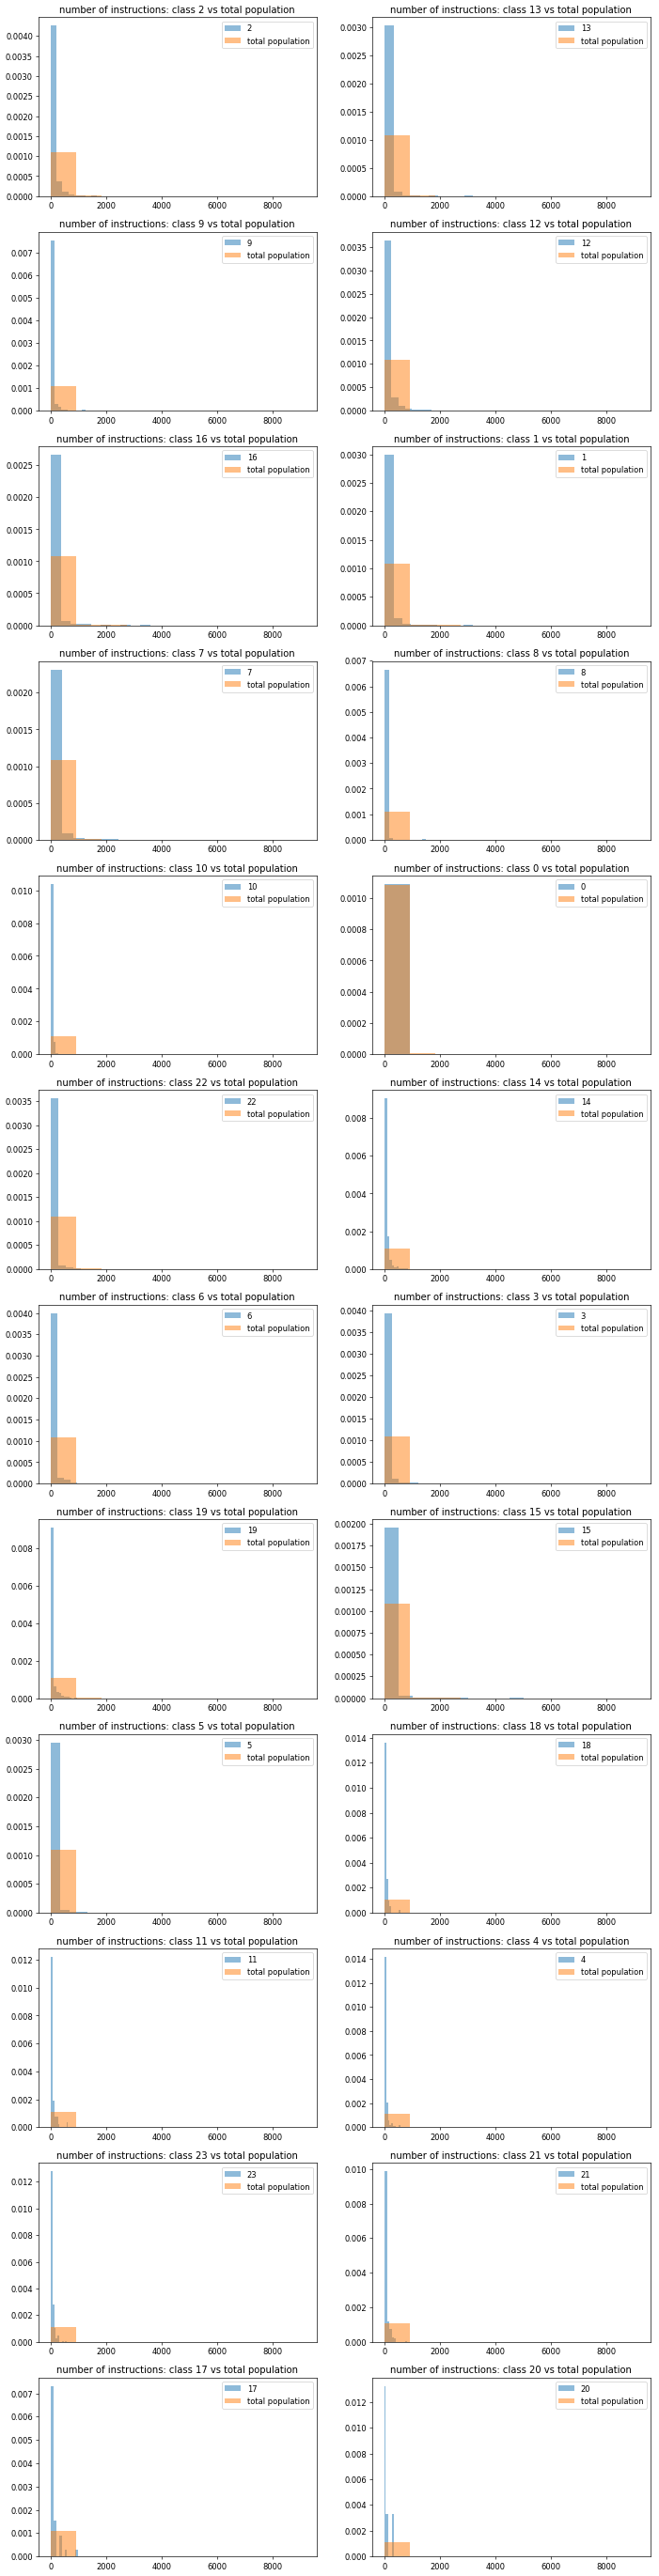

In [44]:
histogram_of_a_features(5,X_train,y_train,features_names)

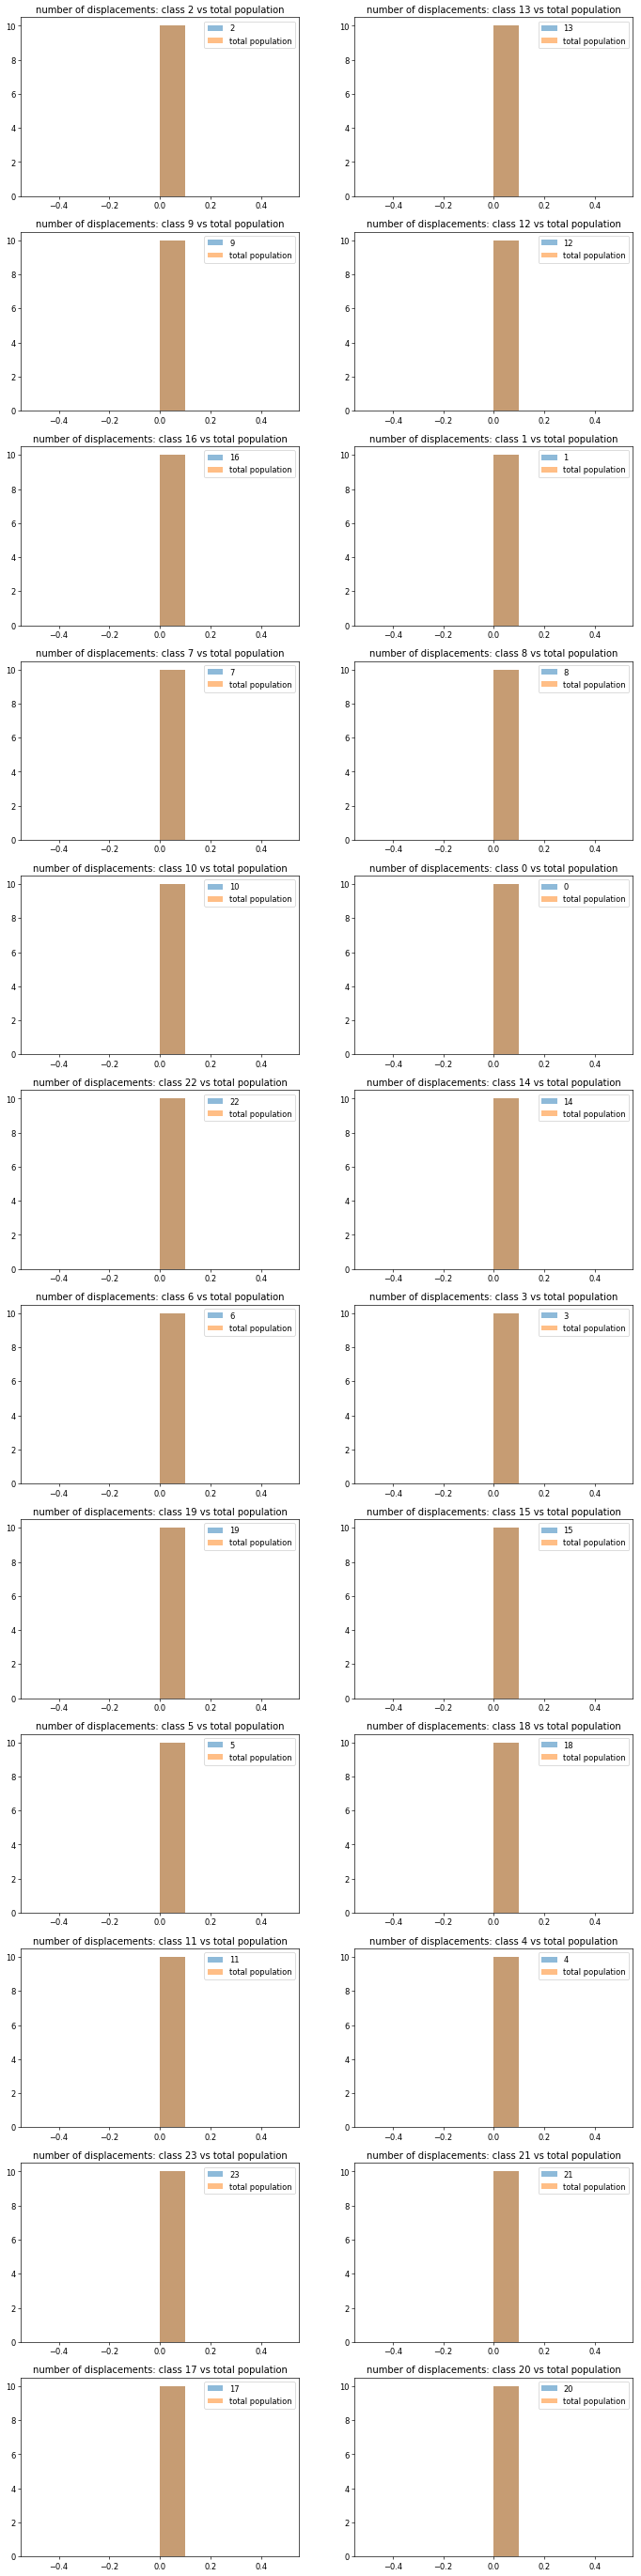

In [45]:
histogram_of_a_features(6,X_train,y_train,features_names)

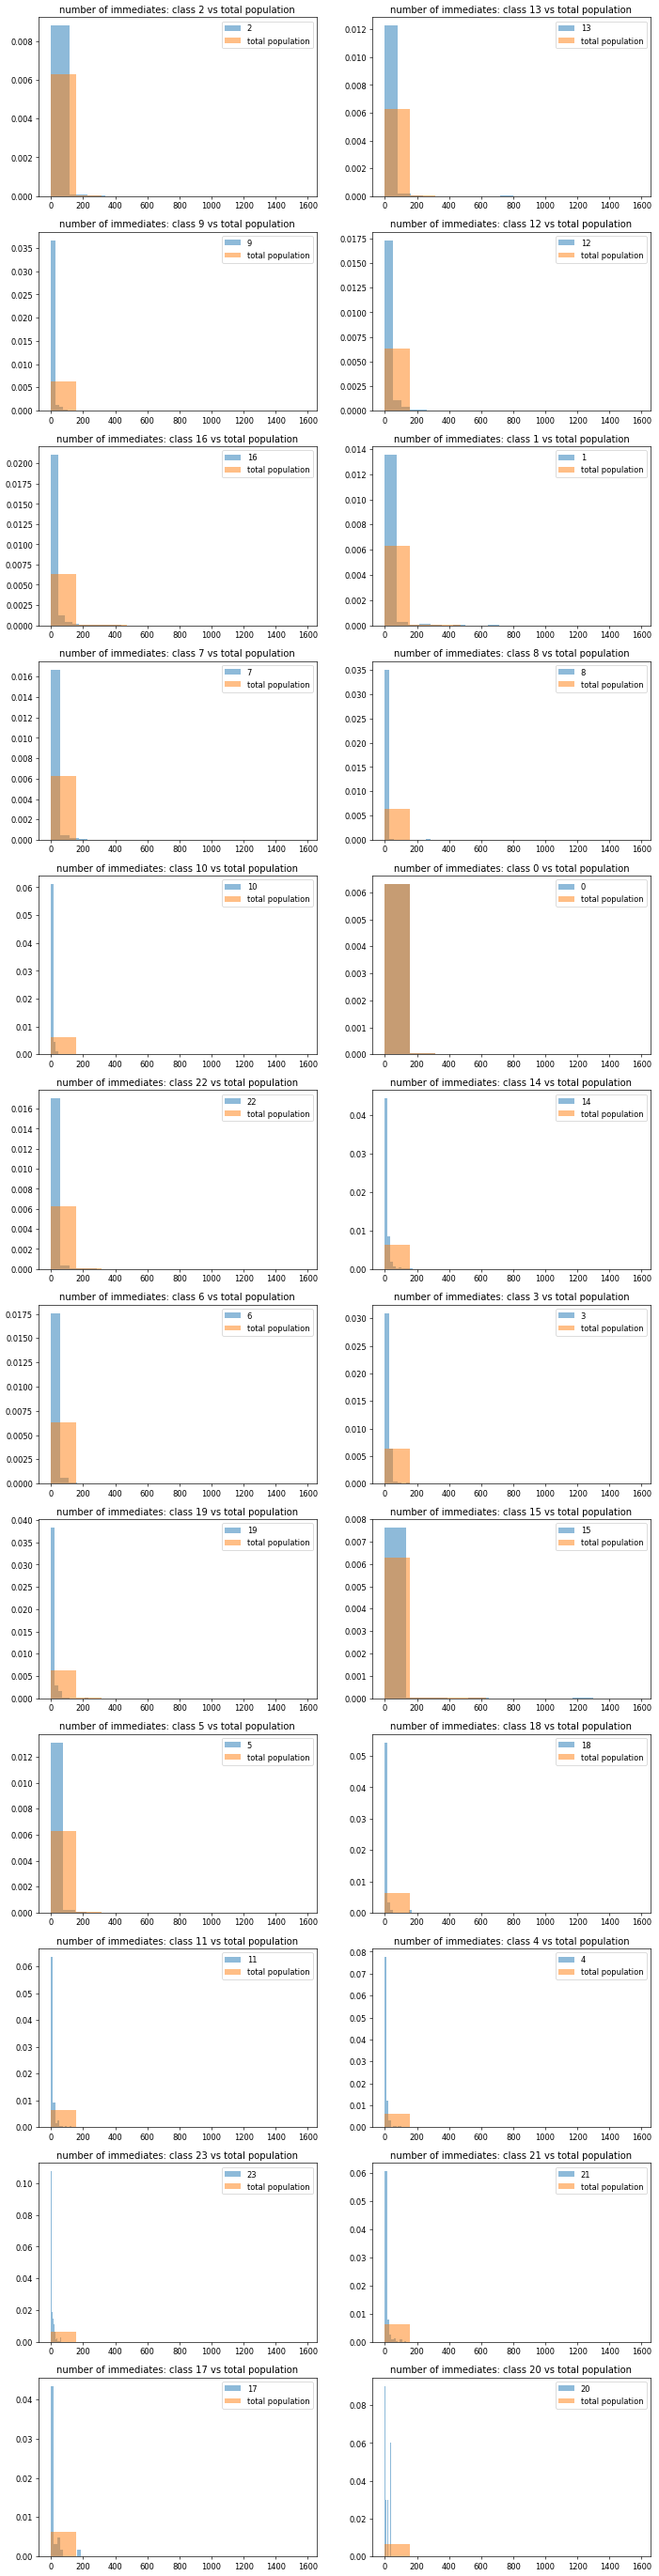

In [46]:
histogram_of_a_features(7,X_train,y_train,features_names)

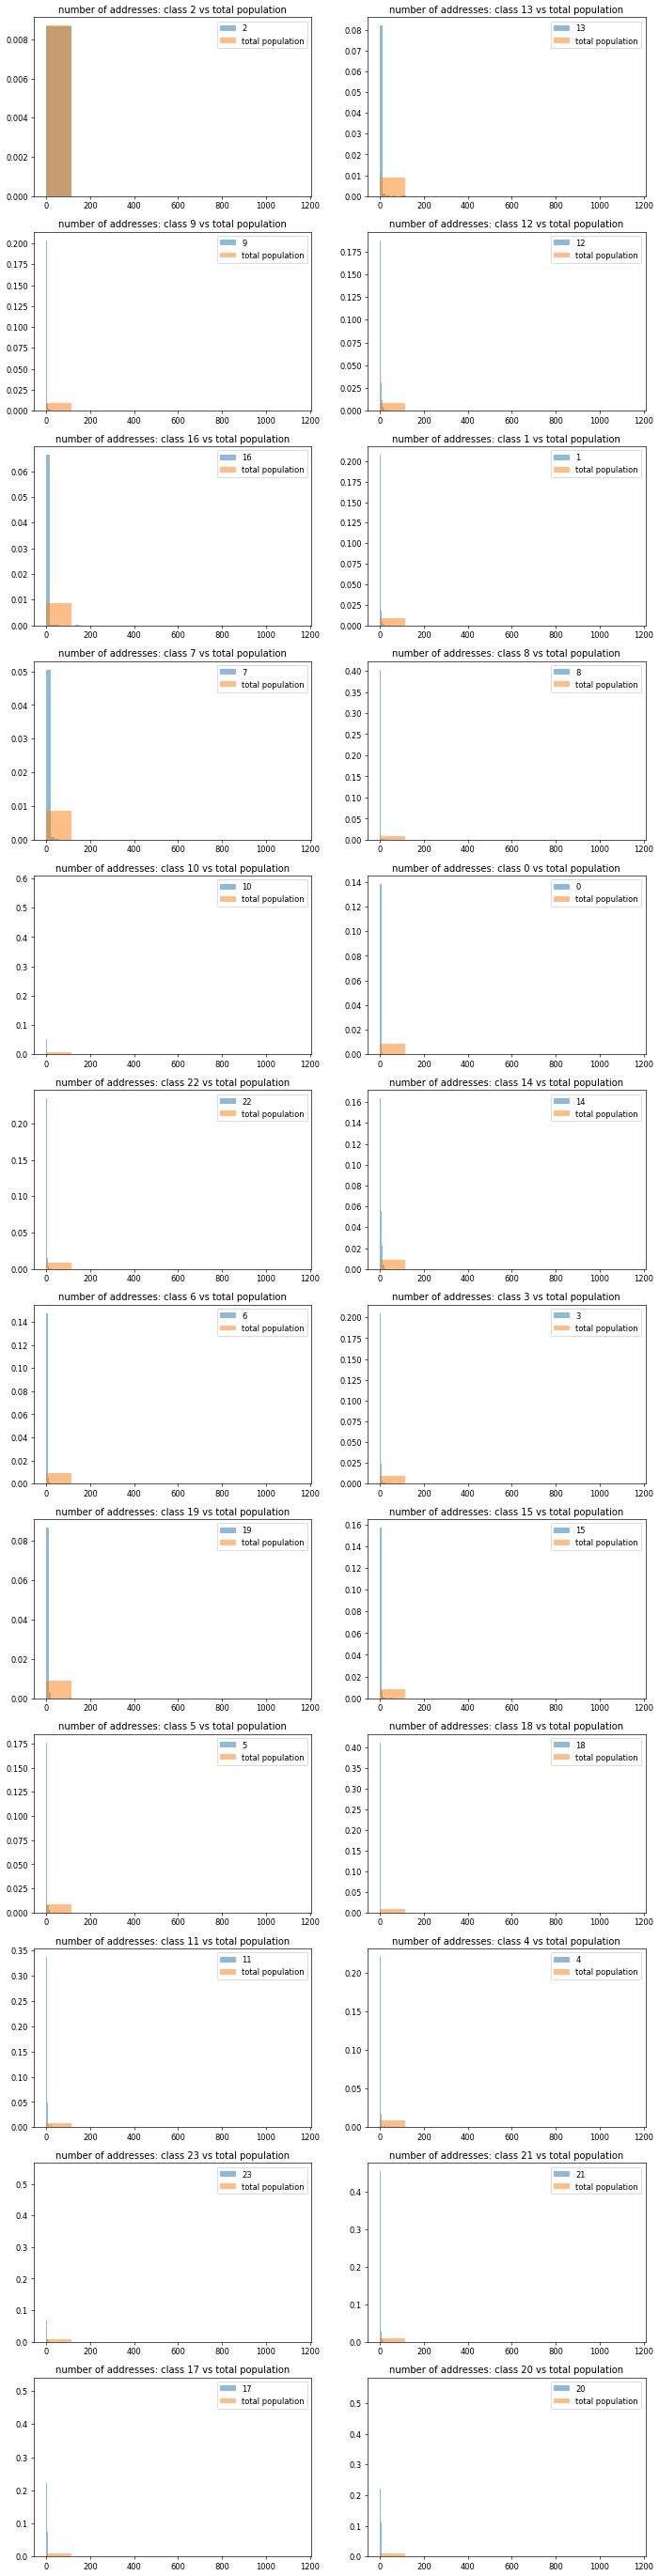

In [47]:
histogram_of_a_features(8,X_train,y_train,features_names)

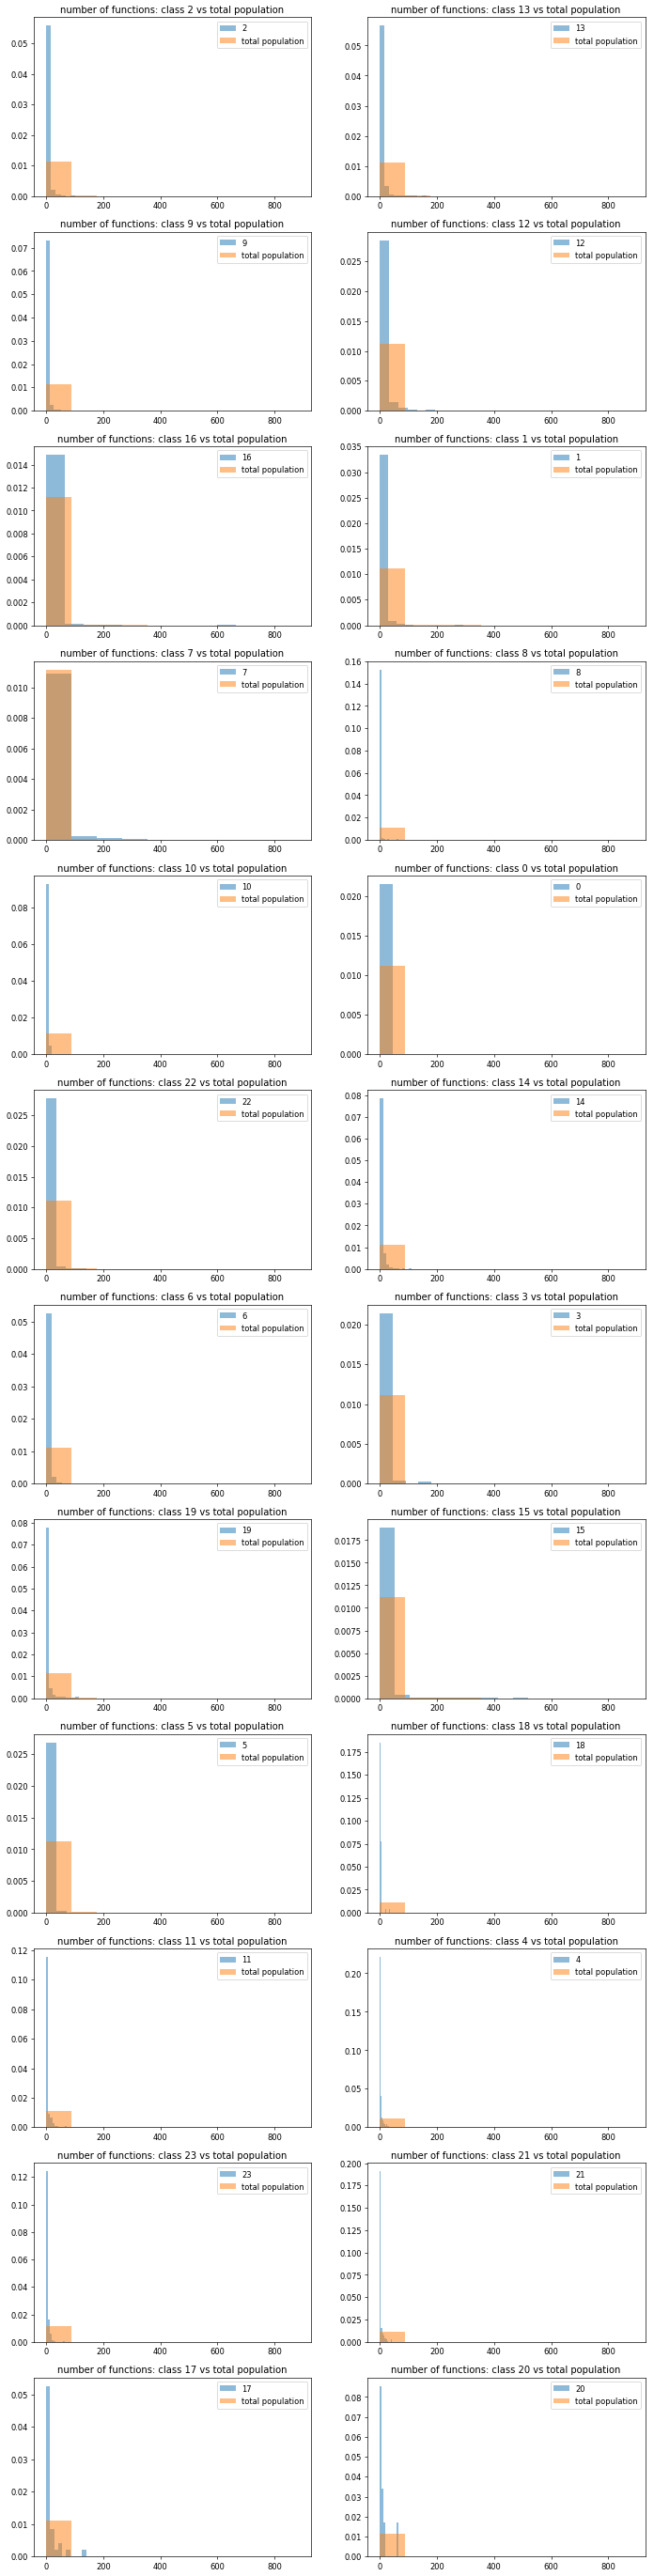

In [48]:
histogram_of_a_features(9,X_train,y_train,features_names) # num regs

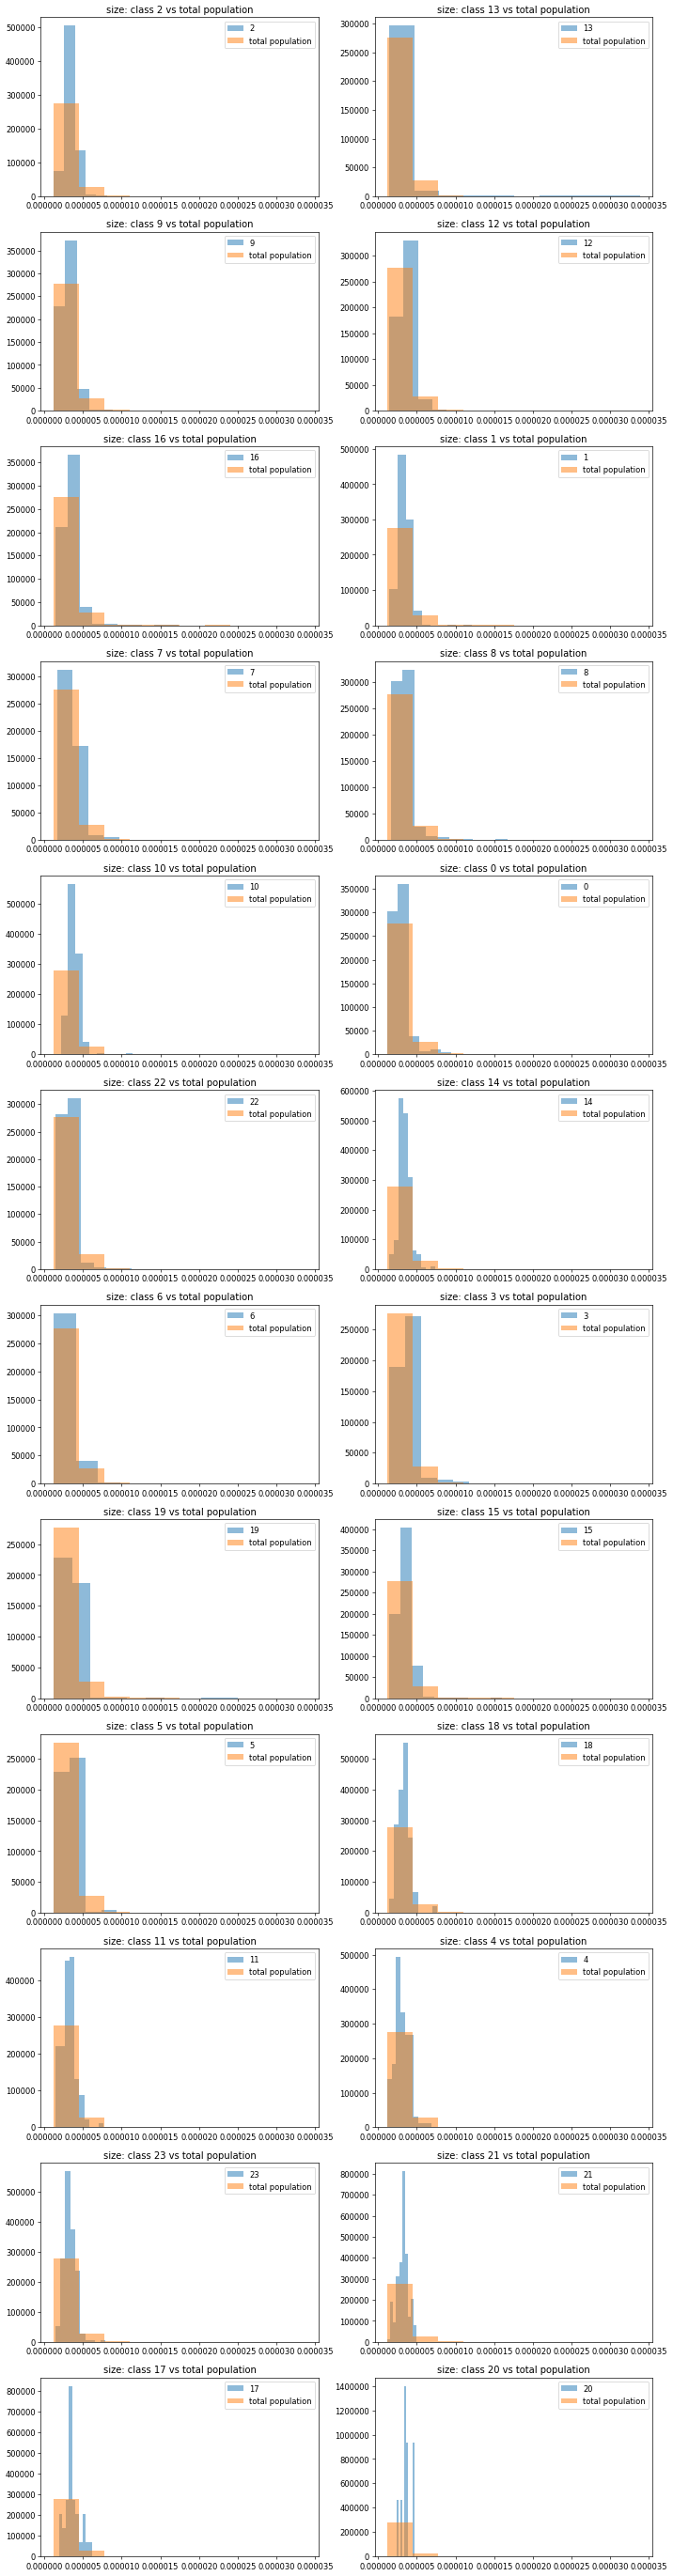

In [49]:
histogram_of_a_features(10,X_train,y_train,features_names) # size

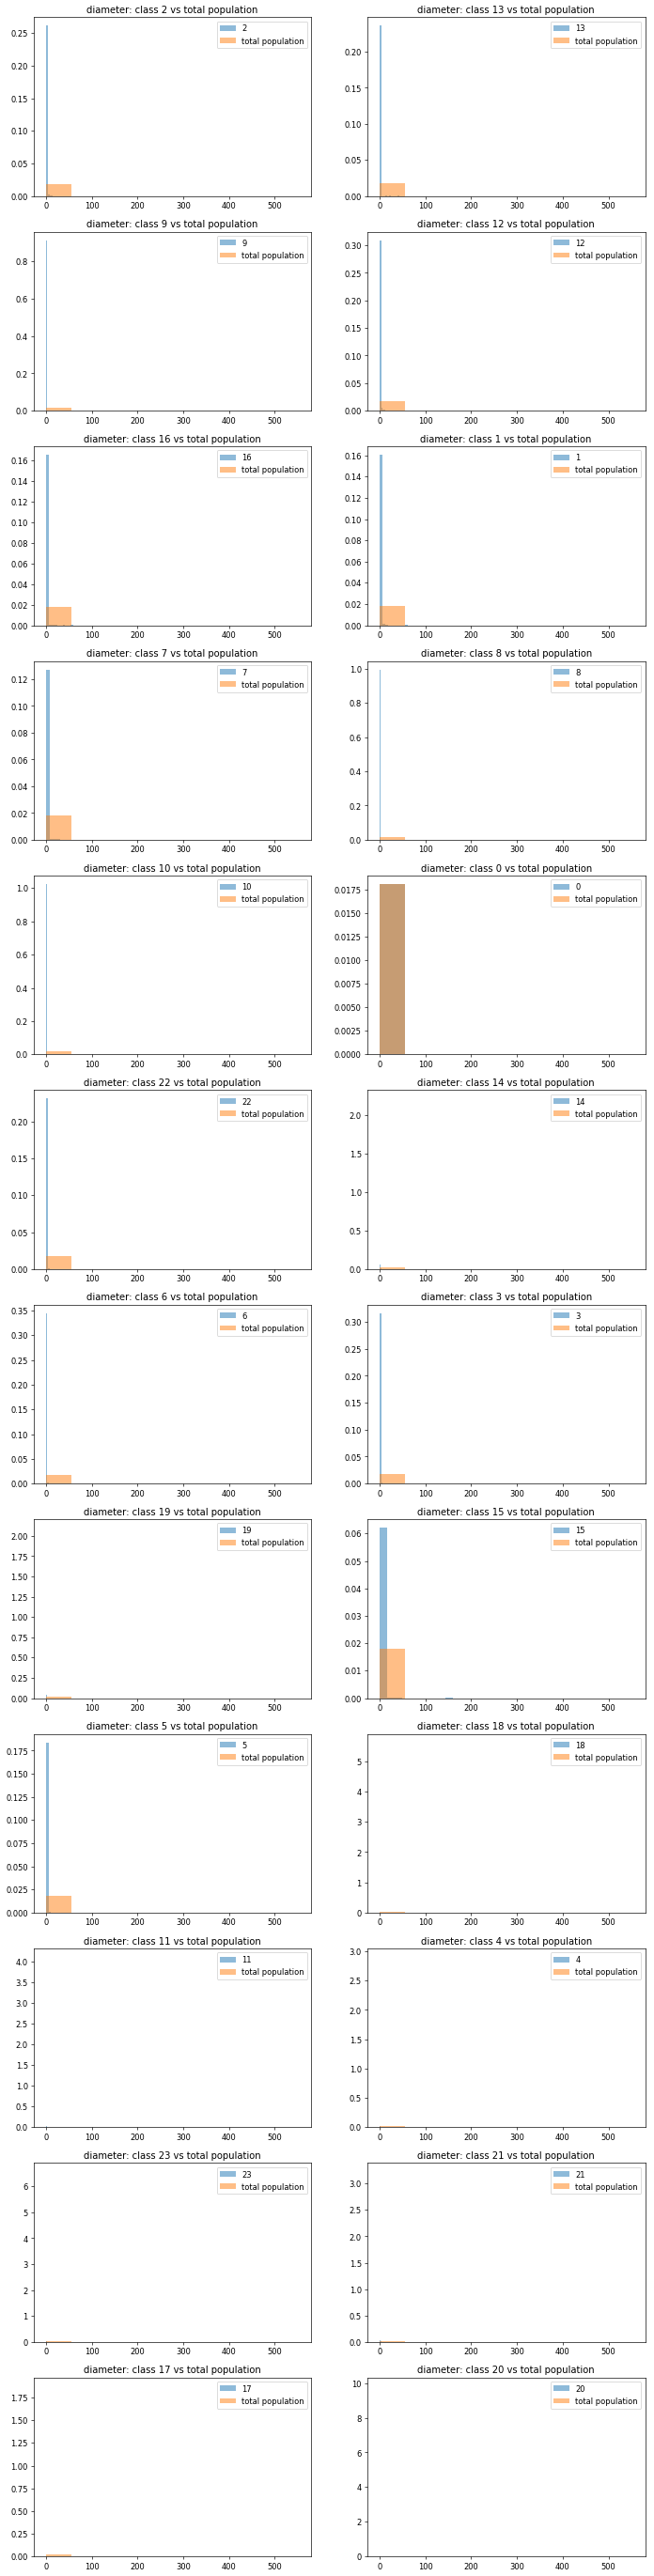

In [50]:
histogram_of_a_features(11,X_train,y_train,features_names) # diameter

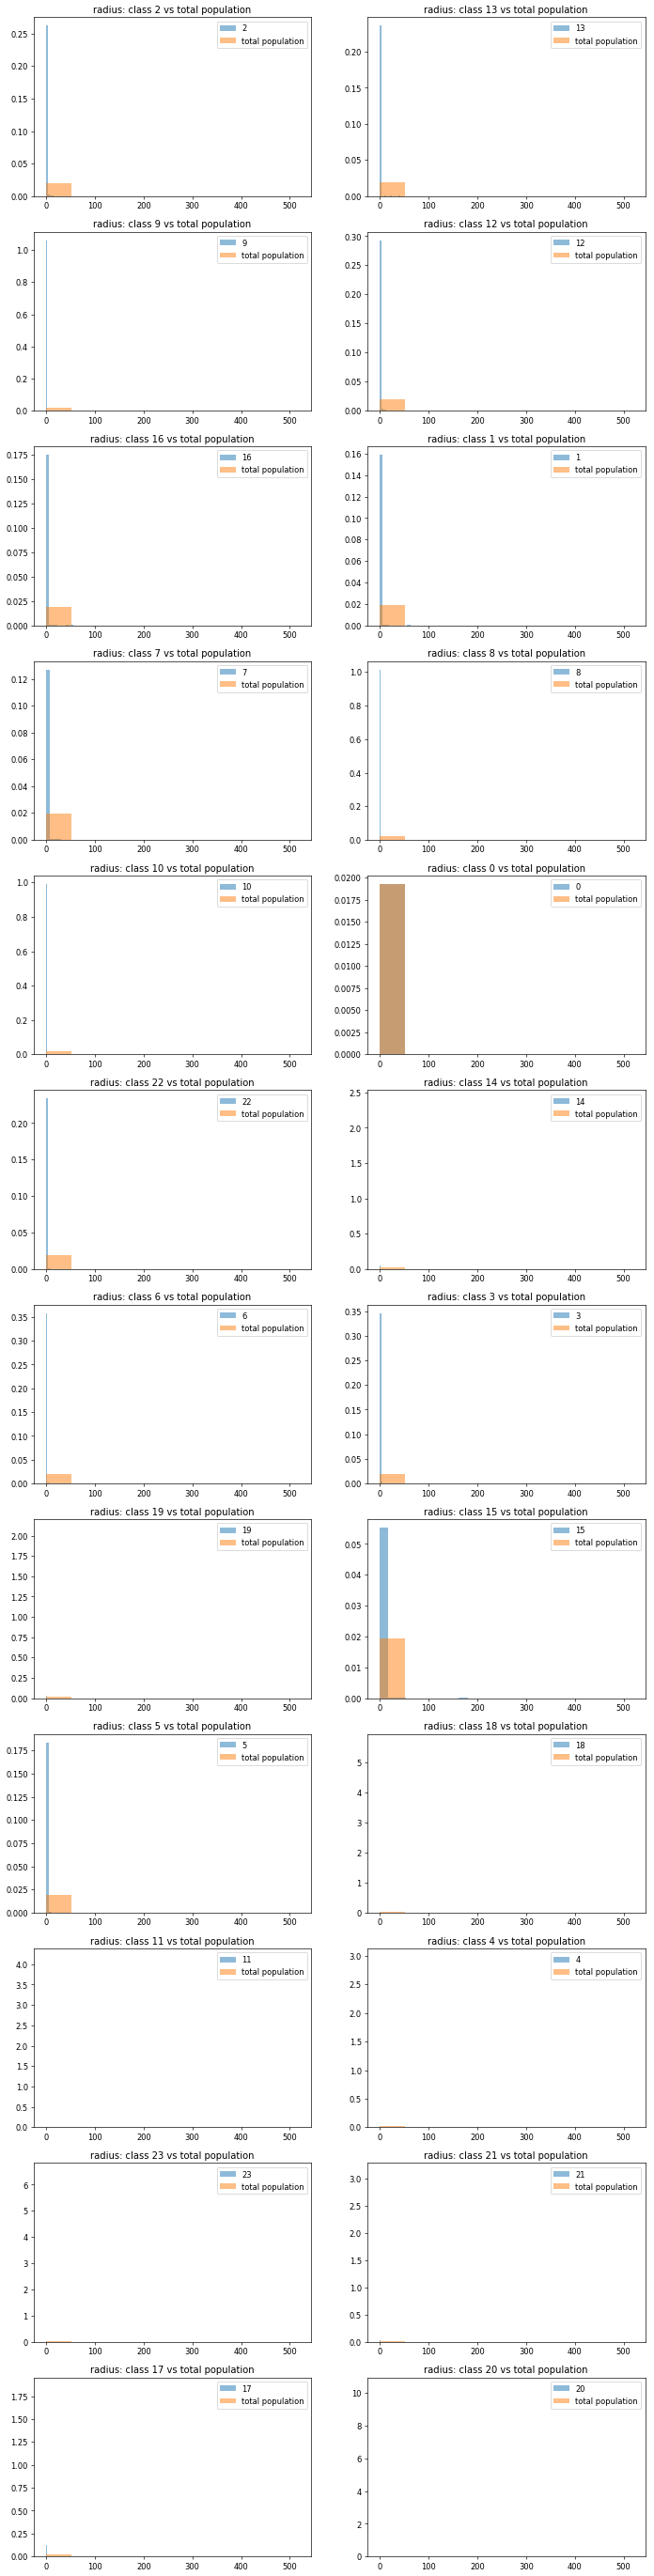

In [51]:
histogram_of_a_features(12,X_train,y_train,features_names) # radius

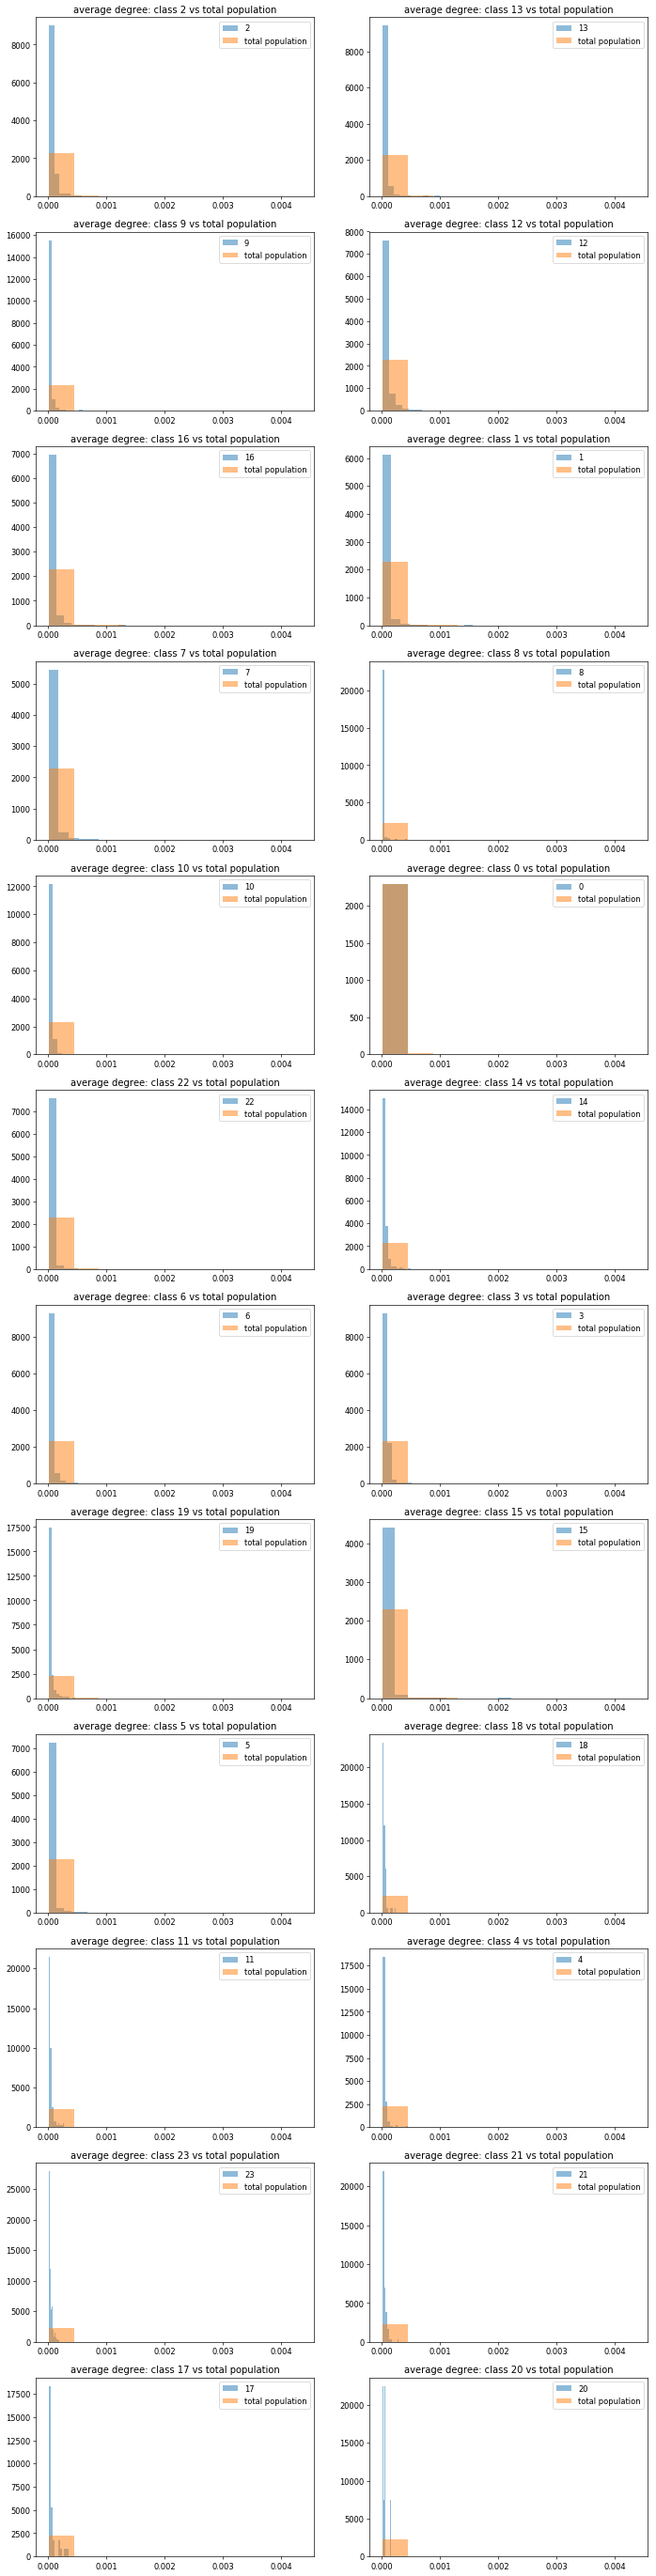

In [52]:
histogram_of_a_features(13,X_train,y_train,features_names) # AVG_DEGREE

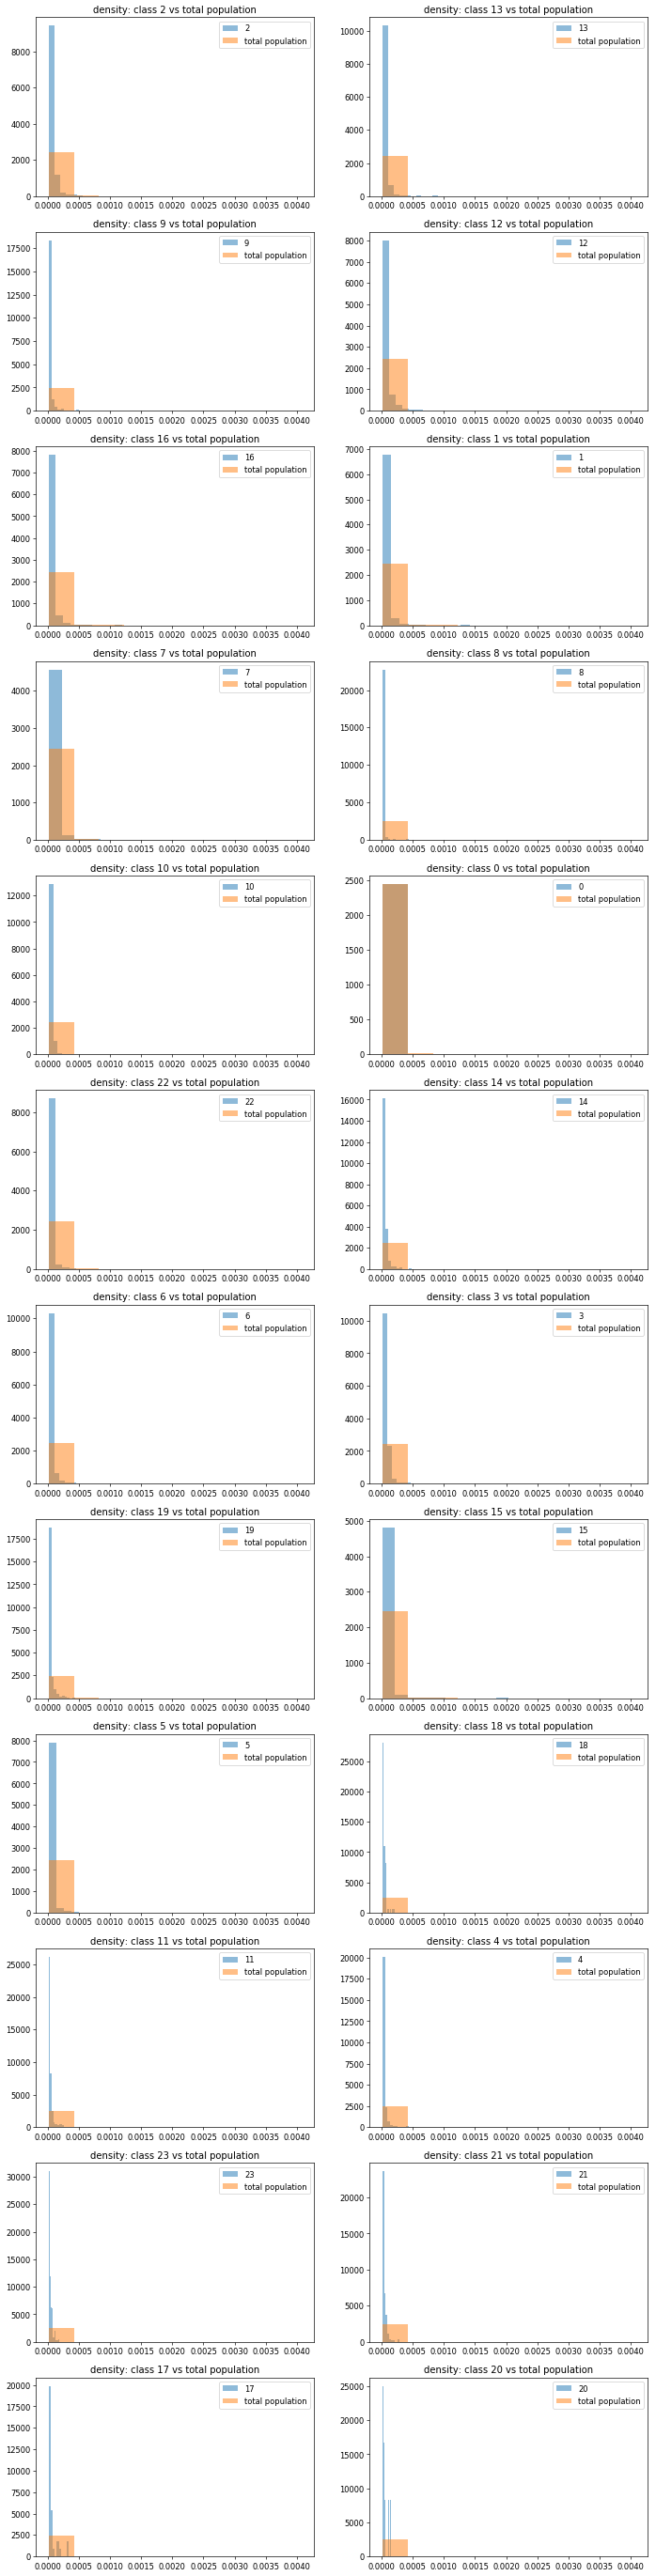

In [53]:
histogram_of_a_features(14,X_train,y_train,features_names) 

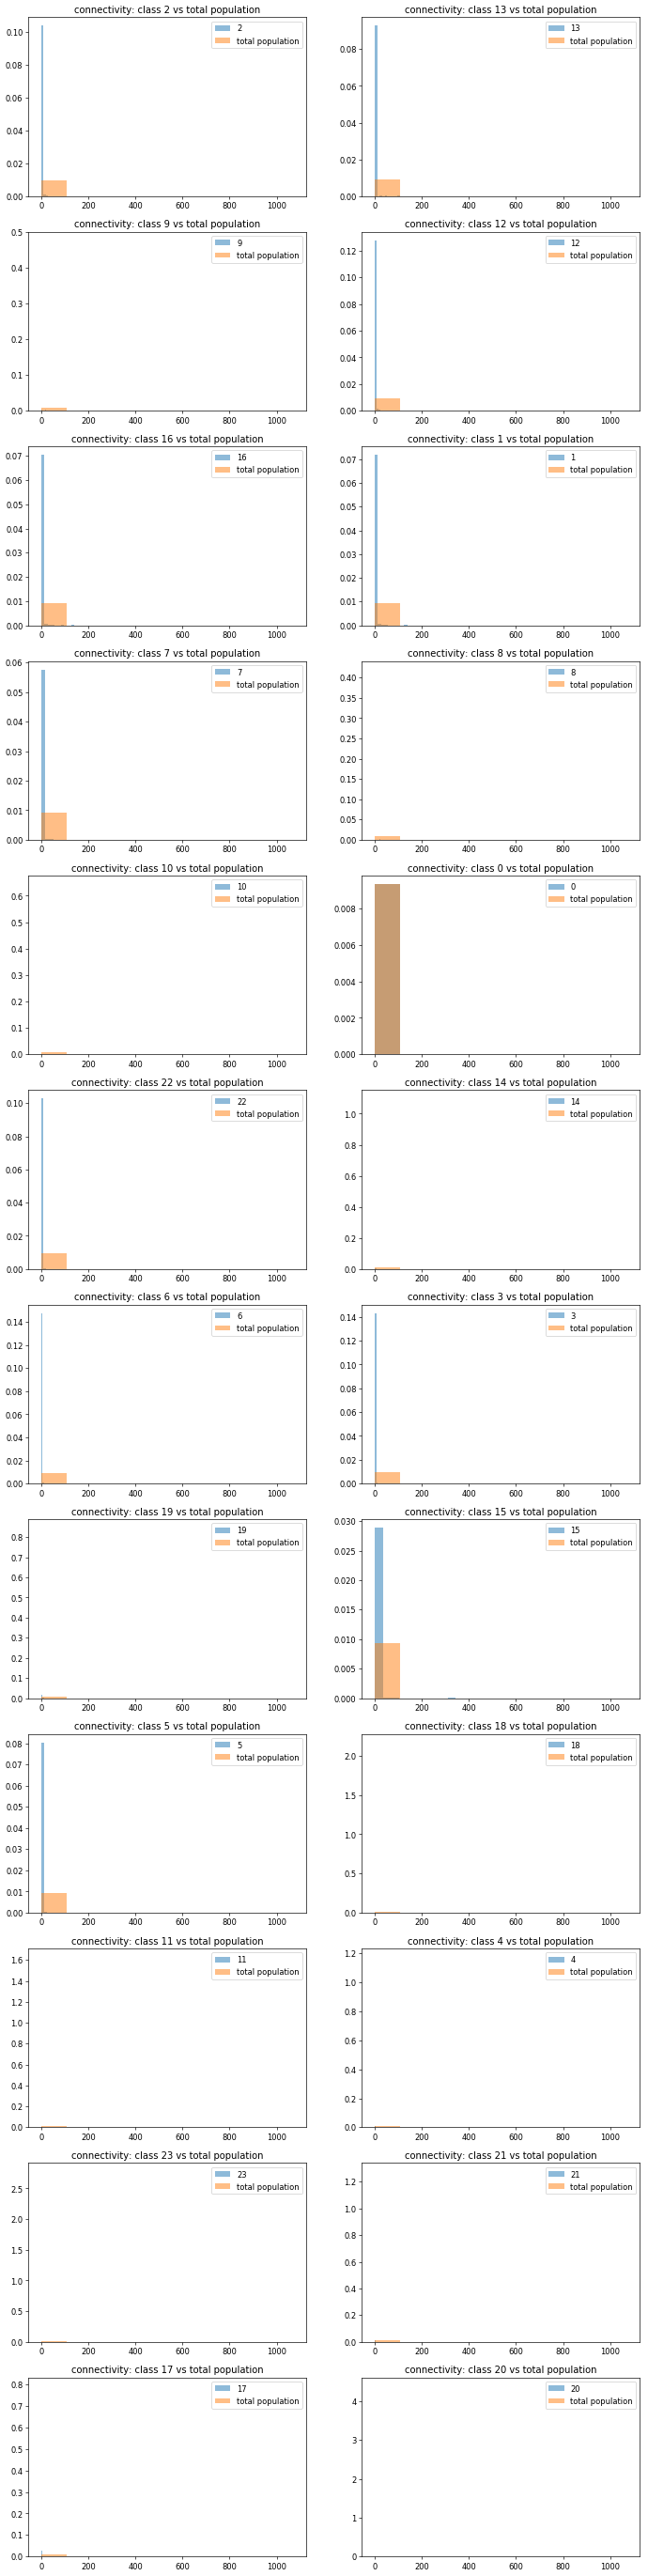

In [54]:
histogram_of_a_features(15,X_train,y_train,features_names) 

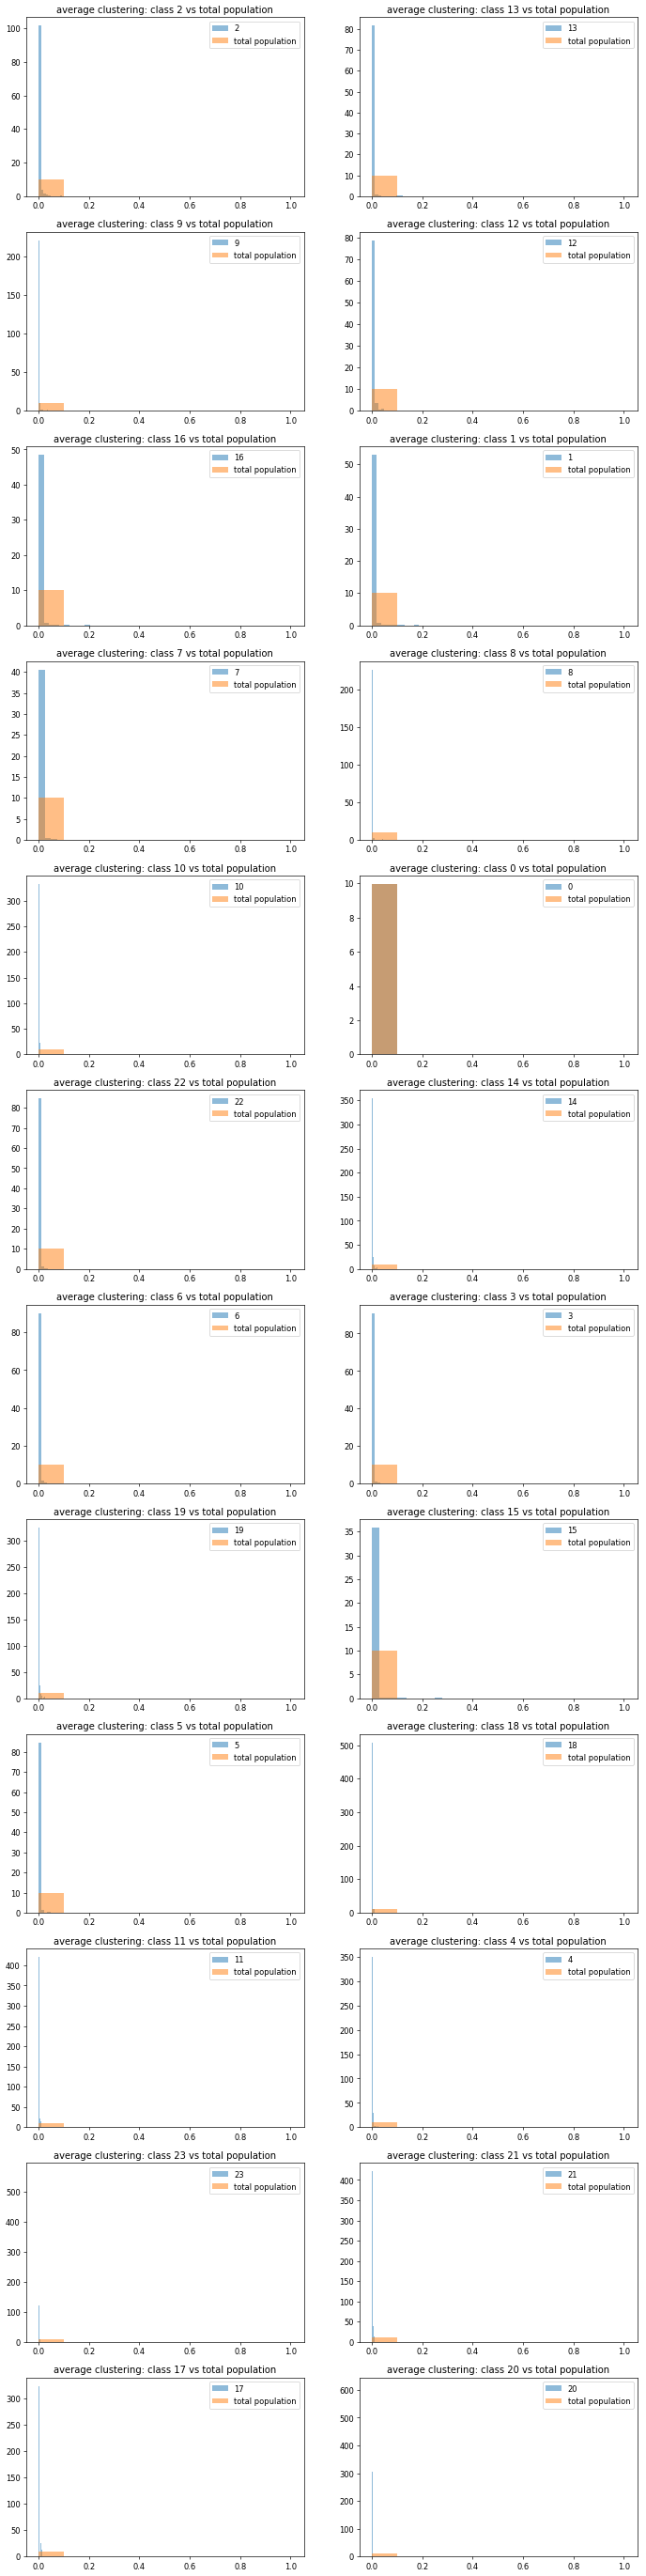

In [55]:
histogram_of_a_features(16,X_train,y_train,features_names) 

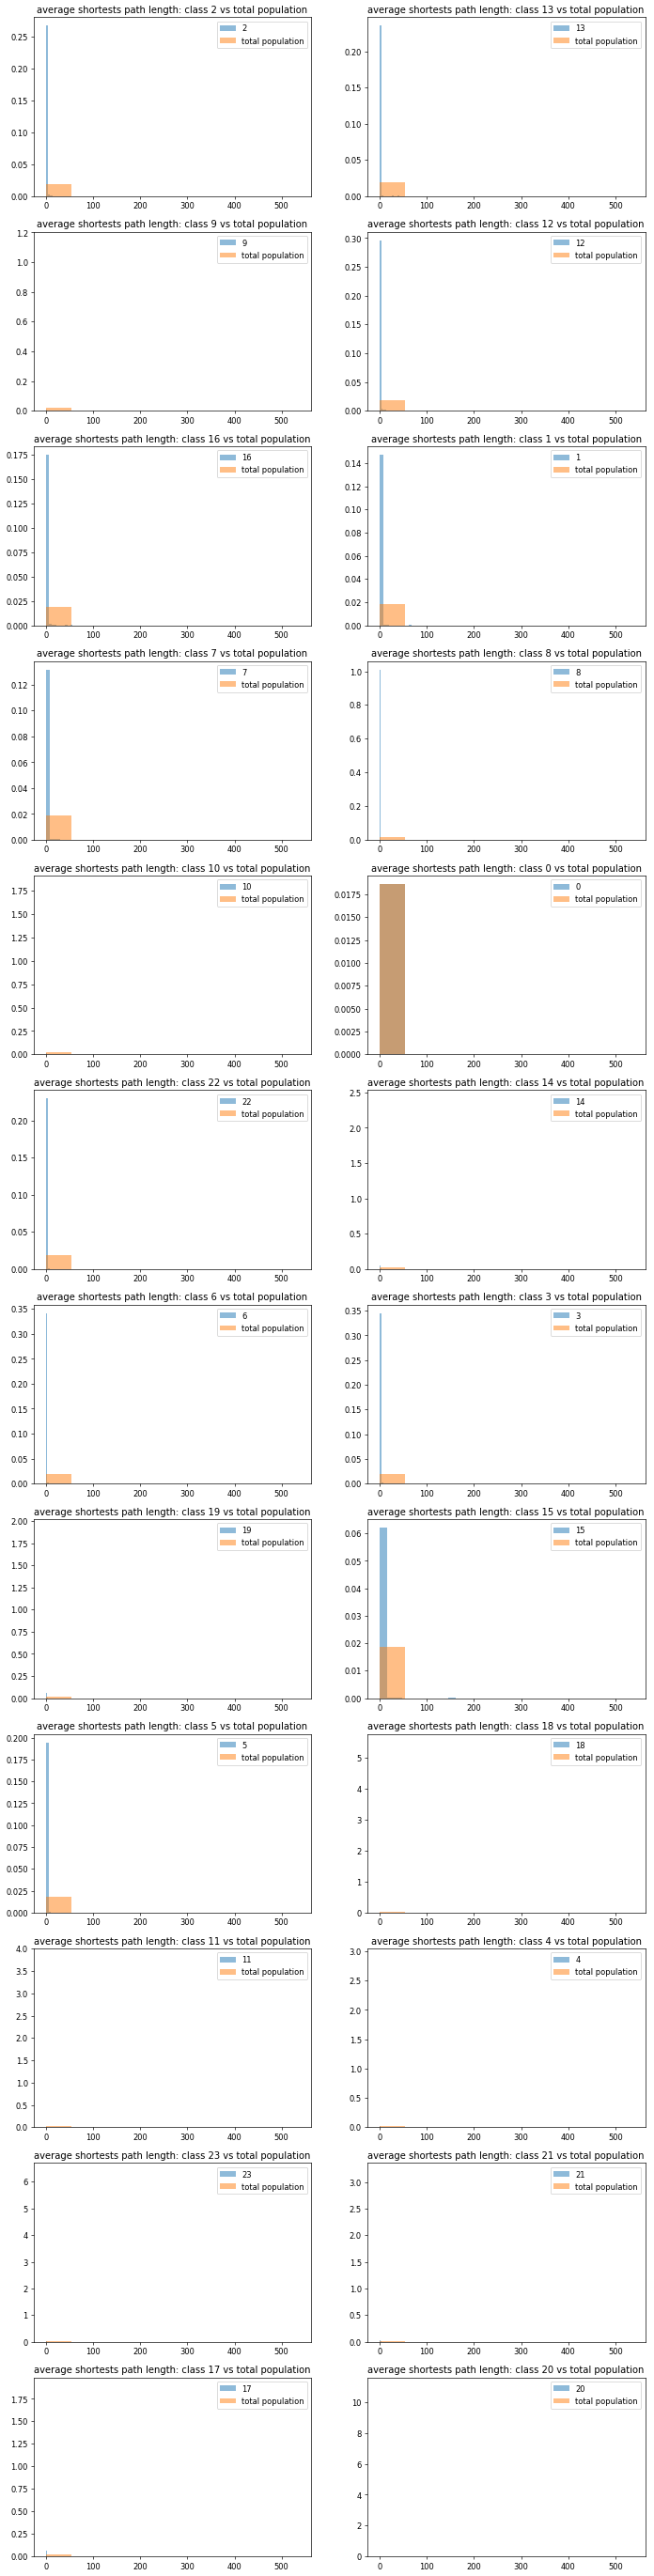

In [56]:
histogram_of_a_features(17,X_train,y_train,features_names) 

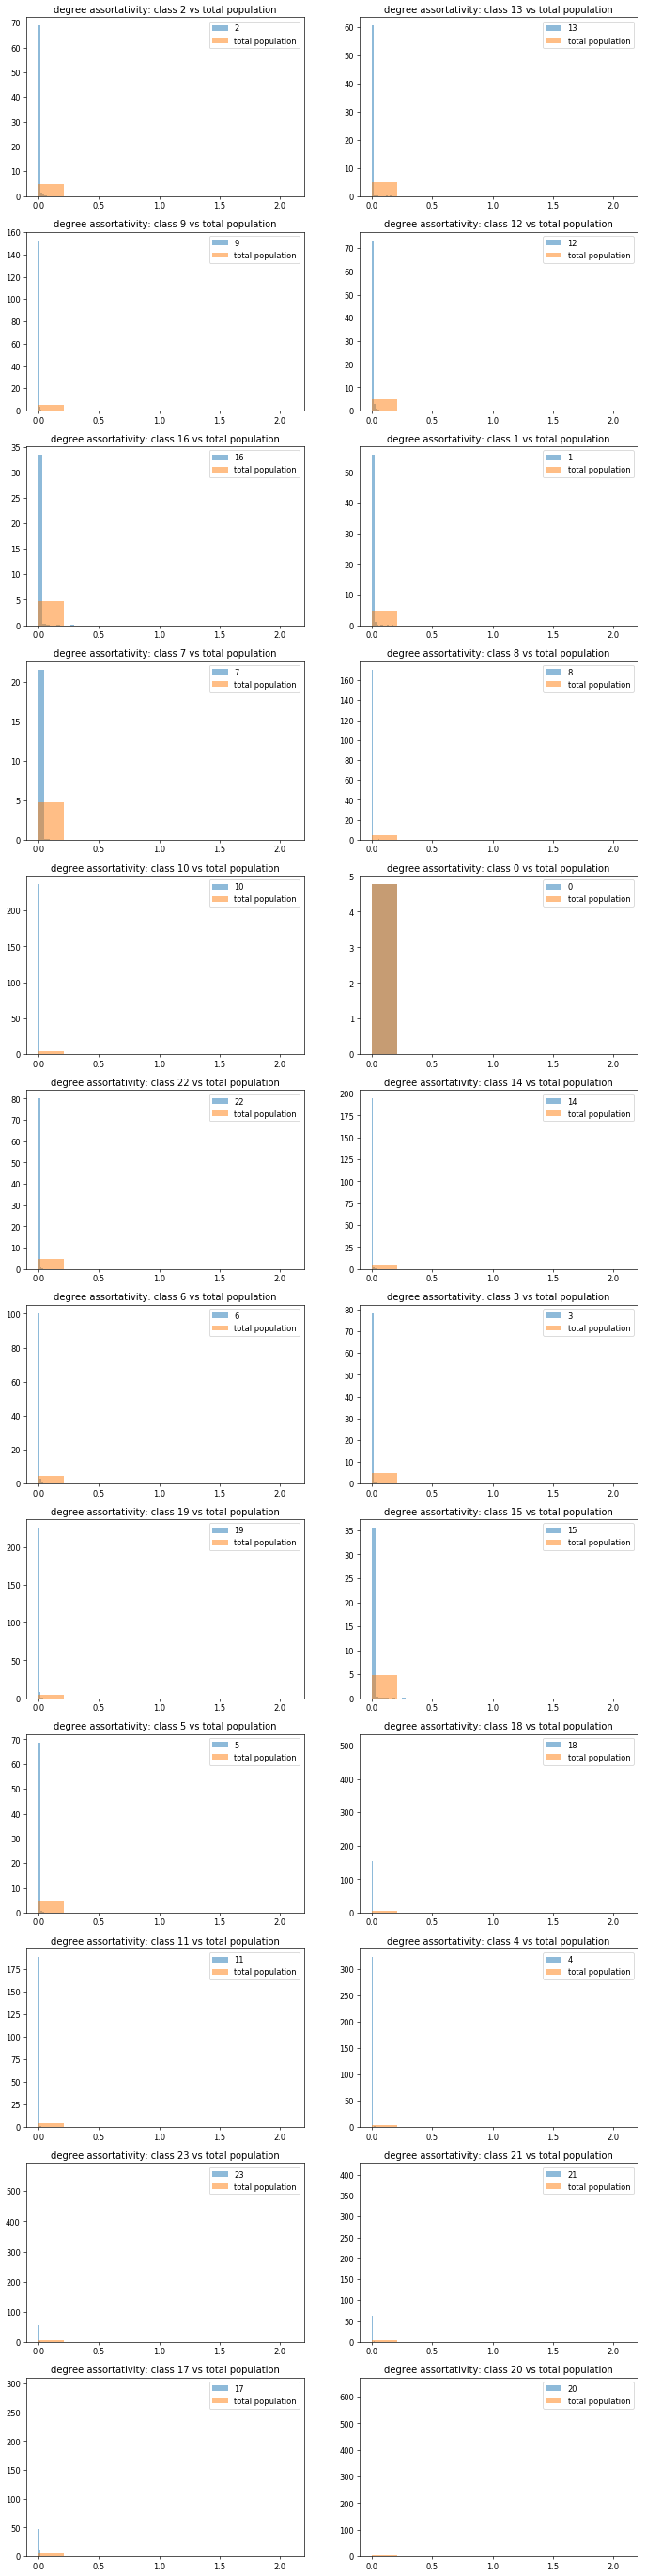

In [57]:
histogram_of_a_features(18,X_train,y_train,features_names) 

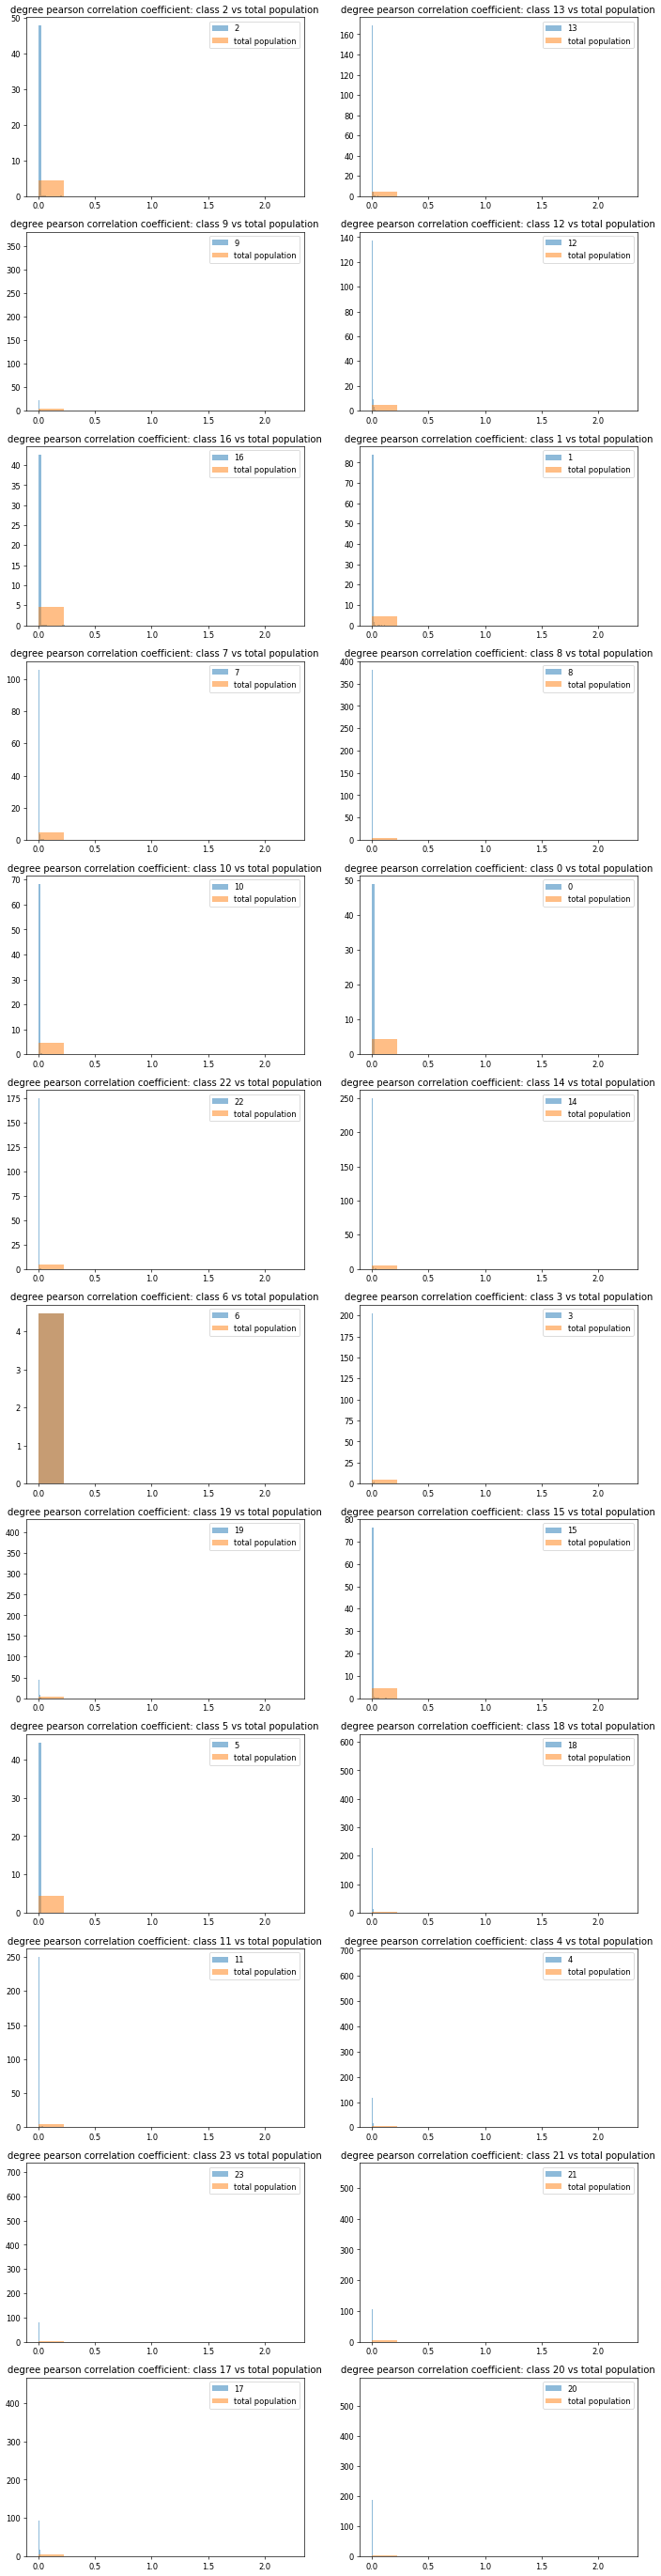

In [58]:
histogram_of_a_features(19,X_train,y_train,features_names)

In [ ]:
# boxplots of each feature for each class (oneplot per feature with all 23 classes inside)

In [ ]:
# ANOVA?

## Proportions of classes in the v1 dataset

In [5]:
#proportions
proportions_unchanged = {0: 27,
 1: 1248,
 2: 1710,
 3: 697,
 4: 4580,
 5: 1378,
 6: 1093,
 7: 5350,
 8: 14653,
 9: 149}
total=0
for i in proportions_unchanged.keys():
    total+=proportions_unchanged[i]
print("total unchanged ",total)
for i in proportions_unchanged.keys():
    print("proportion class ",i," = ",str(proportions_unchanged[i]/total))
    
proportions_undersample = {0: 27,
 1: 1248,
 2: 1710,
 3: 697,
 4: 4580,
 5: 1378,
 6: 1093,
 7: 4581,
 8: 4581,
 9: 149}
total=0
for i in proportions_undersample.keys():
    total+=proportions_undersample[i]
print("total  undersample",total)
for i in proportions_undersample.keys():
    print("proportion class ",i," = ",str(proportions_undersample[i]/total))

total unchanged  30885
proportion class  0  =  0.0008742107819329772
proportion class  1  =  0.040407965031568724
proportion class  2  =  0.055366682855755224
proportion class  3  =  0.02256758944471426
proportion class  4  =  0.14829205115751984
proportion class  5  =  0.044617128055690465
proportion class  6  =  0.035389347579731265
proportion class  7  =  0.173223247531164
proportion class  8  =  0.47443742917273757
proportion class  9  =  0.004824348389185689
total  undersample 20044
proportion class  0  =  0.0013470365196567552
proportion class  1  =  0.06226302135302335
proportion class  2  =  0.0853123129115945
proportion class  3  =  0.03477349830373179
proportion class  4  =  0.2284973059269607
proportion class  5  =  0.06874875274396328
proportion class  6  =  0.0545300339253642
proportion class  7  =  0.22854719616842945
proportion class  8  =  0.22854719616842945
proportion class  9  =  0.007433645978846538


If max proportion in undersampled dataset is 22.8% and algorithm obtains 46% accuracy it means it is not onl detecting the major class. But it could mean it is detecting only the 3 major classes... let's see the classification reports